In [1]:
"""
This program is going to play with a MNIST like dataset called Fashion MNIST
The dataset contains 60000 28x28 pictures, with 10 labels
Most people use this dataset as a toy data for training a DNN model.
However, since tensorflow is unavaible on this computer, the dataset will be used
to train other machine learning models, such as random forest, ensemble, ect.

A DNN model will be trained on my personal mac
"""

'\nThis program is going to play with a MNIST like dataset called Fashion MNIST\nThe dataset contains 60000 28x28 pictures, with 10 labels\nMost people use this dataset as a toy data for training a DNN model.\nHowever, since tensorflow is unavaible on this computer, the dataset will be used\nto train other machine learning models, such as random forest, ensemble, ect.\n\nA DNN model will be trained on my personal mac\n'

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import inspect
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer

# fetch_openml for loading the data
from sklearn.datasets import fetch_openml

# train_test_split for data spliting
from sklearn.model_selection import train_test_split

# Import the metrics for evaluating classification tasks
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, make_scorer

# Import this class for calculating the matrics
from sklearn.model_selection import cross_val_predict

# Import the GridSearchCV for hypermeters tuning
from sklearn.model_selection import GridSearchCV

# Import the Pipe model for pipeline building
from sklearn.pipeline import Pipeline

# Import the StandardScaler
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [121]:
class Comparator:
    def __init__(self, name):
        self.__model = []
        self.__dataset = PrepaData()
        # It's neccessary to give each comparator a name
        self.__comparator_name = name
        
    def set_dataset(self, dataset):
        self.__dataset.data = dataset
        
    def set_estimators(self, estimators):
        self.__estimators = estimators
        
    def get_name(self):
        self.__comparator_name
        
    def comparing(self):
        fig = plt.figure(figsize = (30, 40))
        row_number = len(self.__estimators)
        col_number = 3
        index = 1
        evaluator = ModelEvaluator()
        for estimator in self.__estimators:
            print(f'Creating a model for {estimator.__class__.__name__}')
            model = Model(estimator, self.__dataset, self.__comparator_name)
            evaluator.set_model(model)
            evaluator.super_estimator()
            evaluator.plot_precision_vs_recall(fig, row_number, col_number, index)
            index += 1
            evaluator.plot_roc_curve(fig, row_number, col_number, index)
            index += 1
            evaluator.plot_confu_matrix(fig, row_number, col_number, index)
            index += 1
        plt.tight_layout()
        plt.show()

In [122]:
# Define Model class for an machine learning model
# Which should includ an estimator, an metric_log at least
class Model:
    """
    __init__ creates a model for an estimator
    
    Parameters:
    @estimator: a sklearn estimator
    @dataset: a PrepaData object
    """
    def __init__(self, estimator, dataset, comparator_name):
        self.__estimator = estimator
        self.__metrics_log = MetricsLog(estimator, comparator_name)
        self.__dataset = dataset
    
    def get_training_data(self):
        return self.__dataset.get_data()
    
    def get_training_targets(self):
        return self.__dataset.get_labels()
    
    def get_label_names(self):
        return self.__dataset.get_label_names()
    
    def get_metric(self):
        return self.__metrics_log
    
    def get_estimator(self):
        return self.__estimator

        

In [123]:
# Define PrepaData class for fetching data and spliting data
# Thus we wont be confused by datasets used by different models
class PrepaData:
    """
    This part of code mainly loads a dataset then shows the whole picture of the dataset. 
    Such as the description to the dataset, the color distritubion of each class, as well as 
    part of the samples.
    This class also returns the data and the labels by calling the two get_ classes
    The samples can be printed by calling the function show_img
    """
    def __init__(self):
        self.whole_dataset = fetch_openml(name = 'Fashion-MNIST')
        self.label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] # Creating a list which
                                                                  # contains the names of the 
                                                                  # labels. And the items are
                                                                  # arranged in the same order
                                                                  # as the original labels
        print('-------------------------Description-----------------------------\n')
        print(self.whole_dataset.DESCR)
        print(f'This dataset has {self.whole_dataset.data.shape[0]} samples\n')
        print(f'Each sample has {self.whole_dataset.data.shape[1]} pixels\n')
        print(f'There are {self.whole_dataset.data.shape[0]} targets\n')
        print('-------------------------Description End-----------------------------\n')

    def get_data(self):
        return self.whole_dataset.data
            
    def get_labels(self):
        return self.whole_dataset.target
            
    def get_label_names(self):
        return self.label_names
            
    def show_img(self, fig, imgs, img_indices, row_number, col_number, dim):
        """
        This function helps showing the content of each image
    
        Parameters:
        @fig: a matplotlib Figure object on which the image will be plot
        @imgs: an ndarray which contains the arraies for images needed to be plotted out
        @labels: a string list contains the label which have been label coded
        @label_names: a string list contains the name of clothing each label actually represents
        @row_number, col_number: integers, define the plotting grid dimension
        """
        imgs = imgs[img_indices]
        labels = self.whole_dataset.target[img_indices]
        index = len(labels)
    
        for i in range(index):
            ax = fig.add_subplot(row_number, col_number, i + 1) # Generating an Axes object. i + 1
                                                            # because of the index of the plot
                                                            # grid starts from 1. 
            image = imgs[i].reshape([dim, dim]) # The dataset fetched using fetch_openml returns
                                          # the images with each being stored as an 1D array
            ax.imshow(image)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            title = self.label_names[int(labels[i])] # int() converts a string into an integer
            ax.set_title(title)
        plt.show()
        
    def color_distribution(self, fig, imgs, row_number, dimension):
        class_size = len(self.label_names)
        col_number = int(class_size / row_number) + int(class_size % row_number)
        imgs = imgs
        imgs = imgs.reshape(len(imgs), dimension, dimension)
        labels = self.whole_dataset.target.astype(int)
        label_names = self.label_names
        
        for i in range(len(label_names)):
            img_matrices = imgs[labels == i]
            
            img_avg = img_matrices.sum(axis = 0) / (len(img_matrices) * 255)
            ax = fig.add_subplot(row_number, col_number, i + 1)
            ax.hist(img_avg.ravel())
            ax.set_title(label_names[i])
        plt.tight_layout()
        plt.show()
        

-------------------------Description-----------------------------

**Author**: Han Xiao, Kashif Rasul, Roland Vollgraf  
**Source**: [Zalando Research](https://github.com/zalandoresearch/fashion-mnist)  
**Please cite**: Han Xiao and Kashif Rasul and Roland Vollgraf, Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms, arXiv, cs.LG/1708.07747  

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. 

Raw data available at: https://github.com/zalandoresearch/fashion-mnist

### Target classes
Each training and test example is assigned to one of the following labels:
Label  Descr

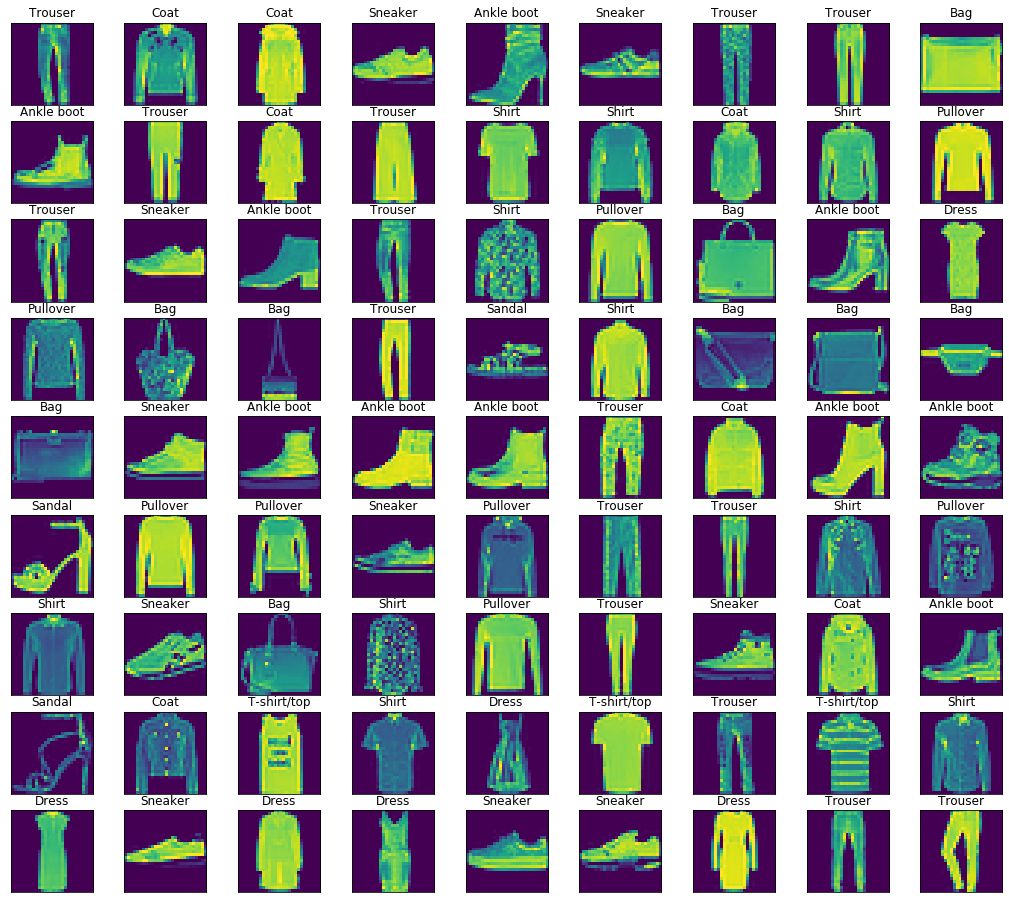

In [6]:
# Preparing the dataset
dataset = PrepaData()

# Let's take a look at the new MNIST like dataset
# Randomly generating 81 integers in between 0-69999
# Taking out the samples and the labels which are going to be plotted out
example_indices = np.random.randint(low = 0, high = 69999, size = 81)

# Generating a Figure object
# Plotting the images by calling the helper funcion show_img
fig = plt.figure(figsize = (18, 16))
dataset.show_img(fig, dataset.get_data(), example_indices, 9, 9, 28)

In [127]:
# This MetricsLog class is inspired by the History class in keras
# A instantiated MetricsLog records the training metrics and training times

class MetricsLog:
    """
    The History class should store the metrics for evaluating the model's performance,
    seeing if the current model is overfitting or underfitting.
    
    The variables are:
    self.tpr: true positive rate, also called recall or sensitivety
    self.fpr: false positive rate, equals 1 - tnr(True Negative Rate), or 1 - specificity'
    
    The following three variables are used to plot the precision_recall_curve
    self.__tpr
    self.__fpr
    self.__precisions
    self.__recalls
    self.__conf_matrix: confusion matrix
    
    The functions are:
    __init(self, estimator)
    __init__cv_predict_method(self, estimator)
    CalcCvScores(self, estimator, X, y, cv, method)
    """
    
    def __init__(self, estimator, comparator_name):
        """
        __init__ function initiates all the variables and data structures
        """
        self.__tpr = []
        self.__fpr = []
        self.__precisions = []
        self.__recalls = []
        self.__confu_matrix = {}
        self.__current_estimator = estimator
        self.__comparator_name = comparator_name
        
    def __CVPredictMethod(self):
        """
        This is a private helper method for choosing the proper cross_val_predict function
        since different estimators require different calculation methods
        But, VotingClassifier is an exception
        """
        clf_name = self.__current_estimator.__class__.__name__
        method = '?'
        if clf_name == 'VotingClassifier':
            method = 'predict_proba'
        else:
            estimator_members = inspect.getmembers(self.__current_estimator) # Inspect is a built-in model and the
                                                         # getmembers() return the members of 
                                                         # an object. And the members are
                                                         # stored as a list of tuples which
                                                         # store (name, value)
            member_dict = dict(estimator_members) # Convert a list of tuple into a dictionary
            function_flag = ('predict_proba' in member_dict) # If the estimator has the function
                                                         # predict_proba, then True will be
                                                         # assigned to function_flag
            if function_flag:
                method = 'predict_proba'
            else:
                method = 'decision_function'
            
        return method
    
    def calcCVScores(self, X, y, label_names, cv):
        """
        This function calculates the fpr, tpr and roc_auc score
        
        Parameters:
        @X: training set
        @y: training target
        @cv: cross_validation folds
        """
        print('Calculating the cross validation scores')
        
        # Split training data into train and valid sets
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.1, train_size = 0.9, random_state = 42)
        
        # Setting the method parameter by calling the private method __CVPredictMethod()
        method = self.__CVPredictMethod()
        
        # Making a prediction using cross_val_predict
        estimator = self.__current_estimator
        y_test_pred = cross_val_predict(estimator, X_train, y_train, cv = 3)
        
        # Fitting the same estimator
        estimator.fit(X_train, y_train)
        # y_test_pred = estimator.predict(X_valid)
        
        # Calculating and storing the following three metrices for precision_recalls_curve and roc_curve
        binarizer = LabelBinarizer() # LabelBinarizer() encodes multiple labels into a binary sparse matrix
        binarizer.fit(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']) # Targets stored in y_valid are strings! Not
                                                                          # integers nor float numbers. If the array is
                                                                          # the array is an integer array [0, 1, 2, 3, 
                                                                          # 4, 5, 6, 7, 8, 9], the later result 
                                                                          # binarized_y will be an array has only one
                                                                          # element, 0!

        binarized_y = binarizer.transform(y_valid) # Encoding the target array
        
        # An estimator_score stores the score calculates using decision_function for classifier does not have the
        # predict_proba
        estimator_score = None
        if method == 'decision_function':
            estimator_score = estimator.decision_function(X_valid)
        else:
            estimator_score = estimator.predict_proba(X_valid)
        
        # Storing the file path to super_path
        super_path = os.getcwd()
        
        # Creating folders for precision_scores, recall_scores, fpr_scores, tpr_scores
        precision_path = os.path.join(super_path, f'{self.__comparator_name}_precision_scores_{estimator.__class__.__name__}\\')
        recall_path = os.path.join(super_path, f'{self.__comparator_name}_recall_scores_{estimator.__class__.__name__}\\')
        fpr_path = os.path.join(super_path, f'{self.__comparator_name}_fpr_scores_{estimator.__class__.__name__}\\')
        tpr_path = os.path.join(super_path, f'{self.__comparator_name}_tpr_scores_{estimator.__class__.__name__}\\')
        
        # Checking if the directories above existed or not
        # If there's no such a directory, then we will create such a directory
        if os.path.isdir(precision_path) == False:
            os.mkdir(precision_path)
        
        if os.path.isdir(recall_path) == False:
            os.mkdir(recall_path)
            
        if os.path.isdir(fpr_path) == False:
            os.mkdir(fpr_path)
            
        if os.path.isdir(tpr_path) == False:
            os.mkdir(tpr_path)
        
        for index in range(10):
            # Calculating the precision scores and recall scores for each classes of the targets
            # Each column of the binaried_y, estimator_score represents the prediction and the true class of the class
            # represented by the index
            precision, recall, _ = precision_recall_curve(binarized_y[ :, index], estimator_score[ :, index])
            
            # Due to the not too small size of this dataset, we do not want to hold the scores in memroy
            # Instead of storing the scores in memory, we can store them into local disc using np.save
            # Since each scores are orignally stored in numpy array, so we just store them as .npy file
            # File names are formed in the same pattern: {name of the score}_{estimator name}_{class index}.npy
            precision_file_name = f'{precision_path}Precision_{estimator.__class__.__name__}_class{index}.npy'
            recall_file_name = f'{recall_path}Recall_{estimator.__class__.__name__}_class{index}.npy'
            
            self.__precisions.append(precision_file_name)
            self.__recalls.append(recall_file_name)
            np.save(precision_file_name, precision)
            np.save(recall_file_name, recall)
            
            fpr, tpr, _ = roc_curve(binarized_y[ :, index], estimator_score[ :, index])
            
            fpr_file_name = f'{fpr_path}fpr_{estimator.__class__.__name__}_class{index}.npy'
            tpr_file_name = f'{tpr_path}tpr_{estimator.__class__.__name__}_class{index}.npy'
            self.__fpr.append(fpr_file_name)
            self.__tpr.append(tpr_file_name)
            np.save(fpr_file_name, fpr)
            np.save(tpr_file_name, tpr)
            
    # Calculating and storing the confusion matrix for the estimator in hand
    def calc_confu_matrix(self, X_test, y_test):
        print('Calculating the confusion matrix')
        y_pred = self.__current_estimator.predict(X_test)
        # confu_matrix = confusion_matrix(y_true = y_test, y_pred = y_pred, normalize = 'all')
        confu_matrix = confusion_matrix(y_test, y_pred, normalize = 'all')
        # print(self.__current_estimator.__class__.__name__)
        # print(confu_matrix)
        
        super_path = os.getcwd()
        confu_matrix_path = os.path.join(super_path, f'{self.__comparator_name}_confu_matrix_{self.__current_estimator.__class__.__name__}\\')
        
        if os.path.isdir(confu_matrix_path) == False:
            os.mkdir(confu_matrix_path)
        
        confu_matrix_name = f'{confu_matrix_path}confu_matrix_{self.__current_estimator.__class__.__name__}.npy'
        self.__confu_matrix[self.__current_estimator.__class__.__name__] = confu_matrix_name
        np.save(confu_matrix_name, confu_matrix)
        
    def get_fpr(self):
        return self.__fpr
    
    def get_tpr(self):
        return self.__tpr
    
    def get_precision(self):
        return self.__precisions
    
    def get_recall(self):
        return self.__recalls
    
    def get_confu_matrix(self):
        return self.__confu_matrix

In [128]:
# This class for comparing some classic models
# Each model has been created using default value. 
# The outputs would be put together for comparision. And take out the top 3 models
class ModelEvaluator:
    """
    __init__ function
    
    Parameters:
    @model: a model which are going to be evaluated
    @supervised: bool value. True means a set of supervised models are passed into the object
                 otherwise, the object is going to compare several unsupervised models
    """
    def __init__(self, cv = 3, random_state = 42, supervised = True):
        self.cv = cv
        
        self.random_state = random_state
        self.supervised_model = supervised
        
    def set_model(self, model):
        self.model = model
        self.metric = model.get_metric()
        print(f'Setting model evaluator for the model of {model.get_estimator().__class__.__name__}')
    
    def plot_precision_vs_recall(self, fig, row_number, col_number, index):
        """
        Helper function for ploting roc_curve
        
        Parameters:
        @fig: the figure on which the plot will be plotted
        """
        label_names = self.model.get_label_names()
        ax = fig.add_subplot(row_number, col_number, index)
        precision_names = self.metric.get_precision()
        recall_names = self.metric.get_recall()
        
        for index in range(10):
            label_name = label_names[index]
            precision_name = precision_names[index]
            recall_name = recall_names[index]
            precision = np.load(precision_name)
            recall = np.load(recall_name)
            ax.plot(precision, recall, lw = 2,label = label_name)
        ax.set_xlabel('Recalls')
        ax.set_ylabel('Precisions')
        ax.legend(loc = 'best')
        ax.set_title(f'Precisions Vs Recalls Curve for {self.model.get_estimator().__class__.__name__}')
        
    def plot_roc_curve(self, fig, row_number, col_number, index):
        label_names = self.model.get_label_names()
        ax = fig.add_subplot(row_number, col_number, index)
        fpr_names = self.metric.get_fpr()
        tpr_names = self.metric.get_tpr()
        
        for index in range(10):
            label_name = label_names[index]
            fpr_name = fpr_names[index]
            tpr_name = tpr_names[index]
            fpr = np.load(fpr_name)
            tpr = np.load(tpr_name)
            ax.plot(fpr, tpr, lw = 2, label = label_name)
        ax.set_xlabel('True Positive Rate')
        ax.set_ylabel('False Positive Rate')
        ax.legend(loc = 'best')
        ax.set_title(f'ROC Curve for {self.model.get_estimator().__class__.__name__}')
        
    def plot_confu_matrix(self, fig, row_number, col_number, index):
        ax = fig.add_subplot(row_number, col_number, index)
        matrix_names = self.metric.get_confu_matrix()
        confu_matrix_name = matrix_names[self.model.get_estimator().__class__.__name__]
        confu_matrix = np.load(confu_matrix_name)
        ax = sns.heatmap(confu_matrix, cmap = 'YlGnBu', ax = ax)
        ax.set_label(self.model.get_label_names())
        ax.legend(loc = 'best')
        ax.set_title(f'Confusion Matrix for {self.model.get_estimator().__class__.__name__}')
    
    """
    super_comparator(self, random_state)
    This function initiating the whole process on supervised learning models
    """
    def super_estimator(self):
        if self.supervised_model == True :
            data = self.model.get_training_data()
            labels = self.model.get_training_targets()
            label_names = self.model.get_label_names()
            X_train_full, X_test, y_train_full, y_test = train_test_split(
                    data, labels, test_size = 10000, train_size = 60000, random_state = self.random_state)
            scaler = StandardScaler()
            X_train_full_std = scaler.fit_transform(X_train_full)
            X_test_std = scaler.fit_transform(X_test)
            estimator = self.model.get_estimator()
            metrics_log = self.model.get_metric()
            try:
                X_train_full_std_32 = np.float32(X_train_full_std)
                X_test_std_32 = np.float32(X_test_std)
                metrics_log.calcCVScores(X_train_full_std_32, y_train_full, self.model.get_label_names(), cv = self.cv)
                metrics_log.calc_confu_matrix(X_test_std_32, y_test)
                # metrics_log.calcCVScores(X_train_full_std, y_train_full, self.model.get_label_names(), cv = self.cv)   
                # metrics_log.calc_confu_matrix(X_test_std, y_test)
            except MemoryError:
                print('..............')
                

In [132]:
# Kick up from the linear models
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier

# Import multiclass for sdg
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SGDClassifier(shuffle = True, random_state = 42))
ridge_clf = RidgeClassifier(random_state = 42)
log_reg_clf = LogisticRegression(multi_class = 'ovr', random_state = 42)
pag_clf = PassiveAggressiveClassifier(random_state = 42)
linear_estimators = [ovr_clf, ridge_clf, log_reg_clf, pag_clf]

In [98]:
comparator = Comparator()

-------------------------Description-----------------------------

**Author**: Han Xiao, Kashif Rasul, Roland Vollgraf  
**Source**: [Zalando Research](https://github.com/zalandoresearch/fashion-mnist)  
**Please cite**: Han Xiao and Kashif Rasul and Roland Vollgraf, Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms, arXiv, cs.LG/1708.07747  

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. 

Raw data available at: https://github.com/zalandoresearch/fashion-mnist

### Target classes
Each training and test example is assigned to one of the following labels:
Label  Descr

In [33]:
comparator.set_estimators(estimators)

Instantiating a model for OneVsRestClassifier estimator
Creating model evaluator for the model of OneVsRestClassifier
Calculating the cross validation scores


c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:554: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:554: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:554: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
c:\users\3056986\appdata\local\programs\python\python38\lib\site-pa

Calculating the confusion matrix


No handles with labels found to put in legend.


Instantiating a model for RidgeClassifier estimator
Creating model evaluator for the model of RidgeClassifier
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


Instantiating a model for LogisticRegression estimator
Creating model evaluator for the model of LogisticRegression
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


Instantiating a model for PassiveAggressiveClassifier estimator
Creating model evaluator for the model of PassiveAggressiveClassifier
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


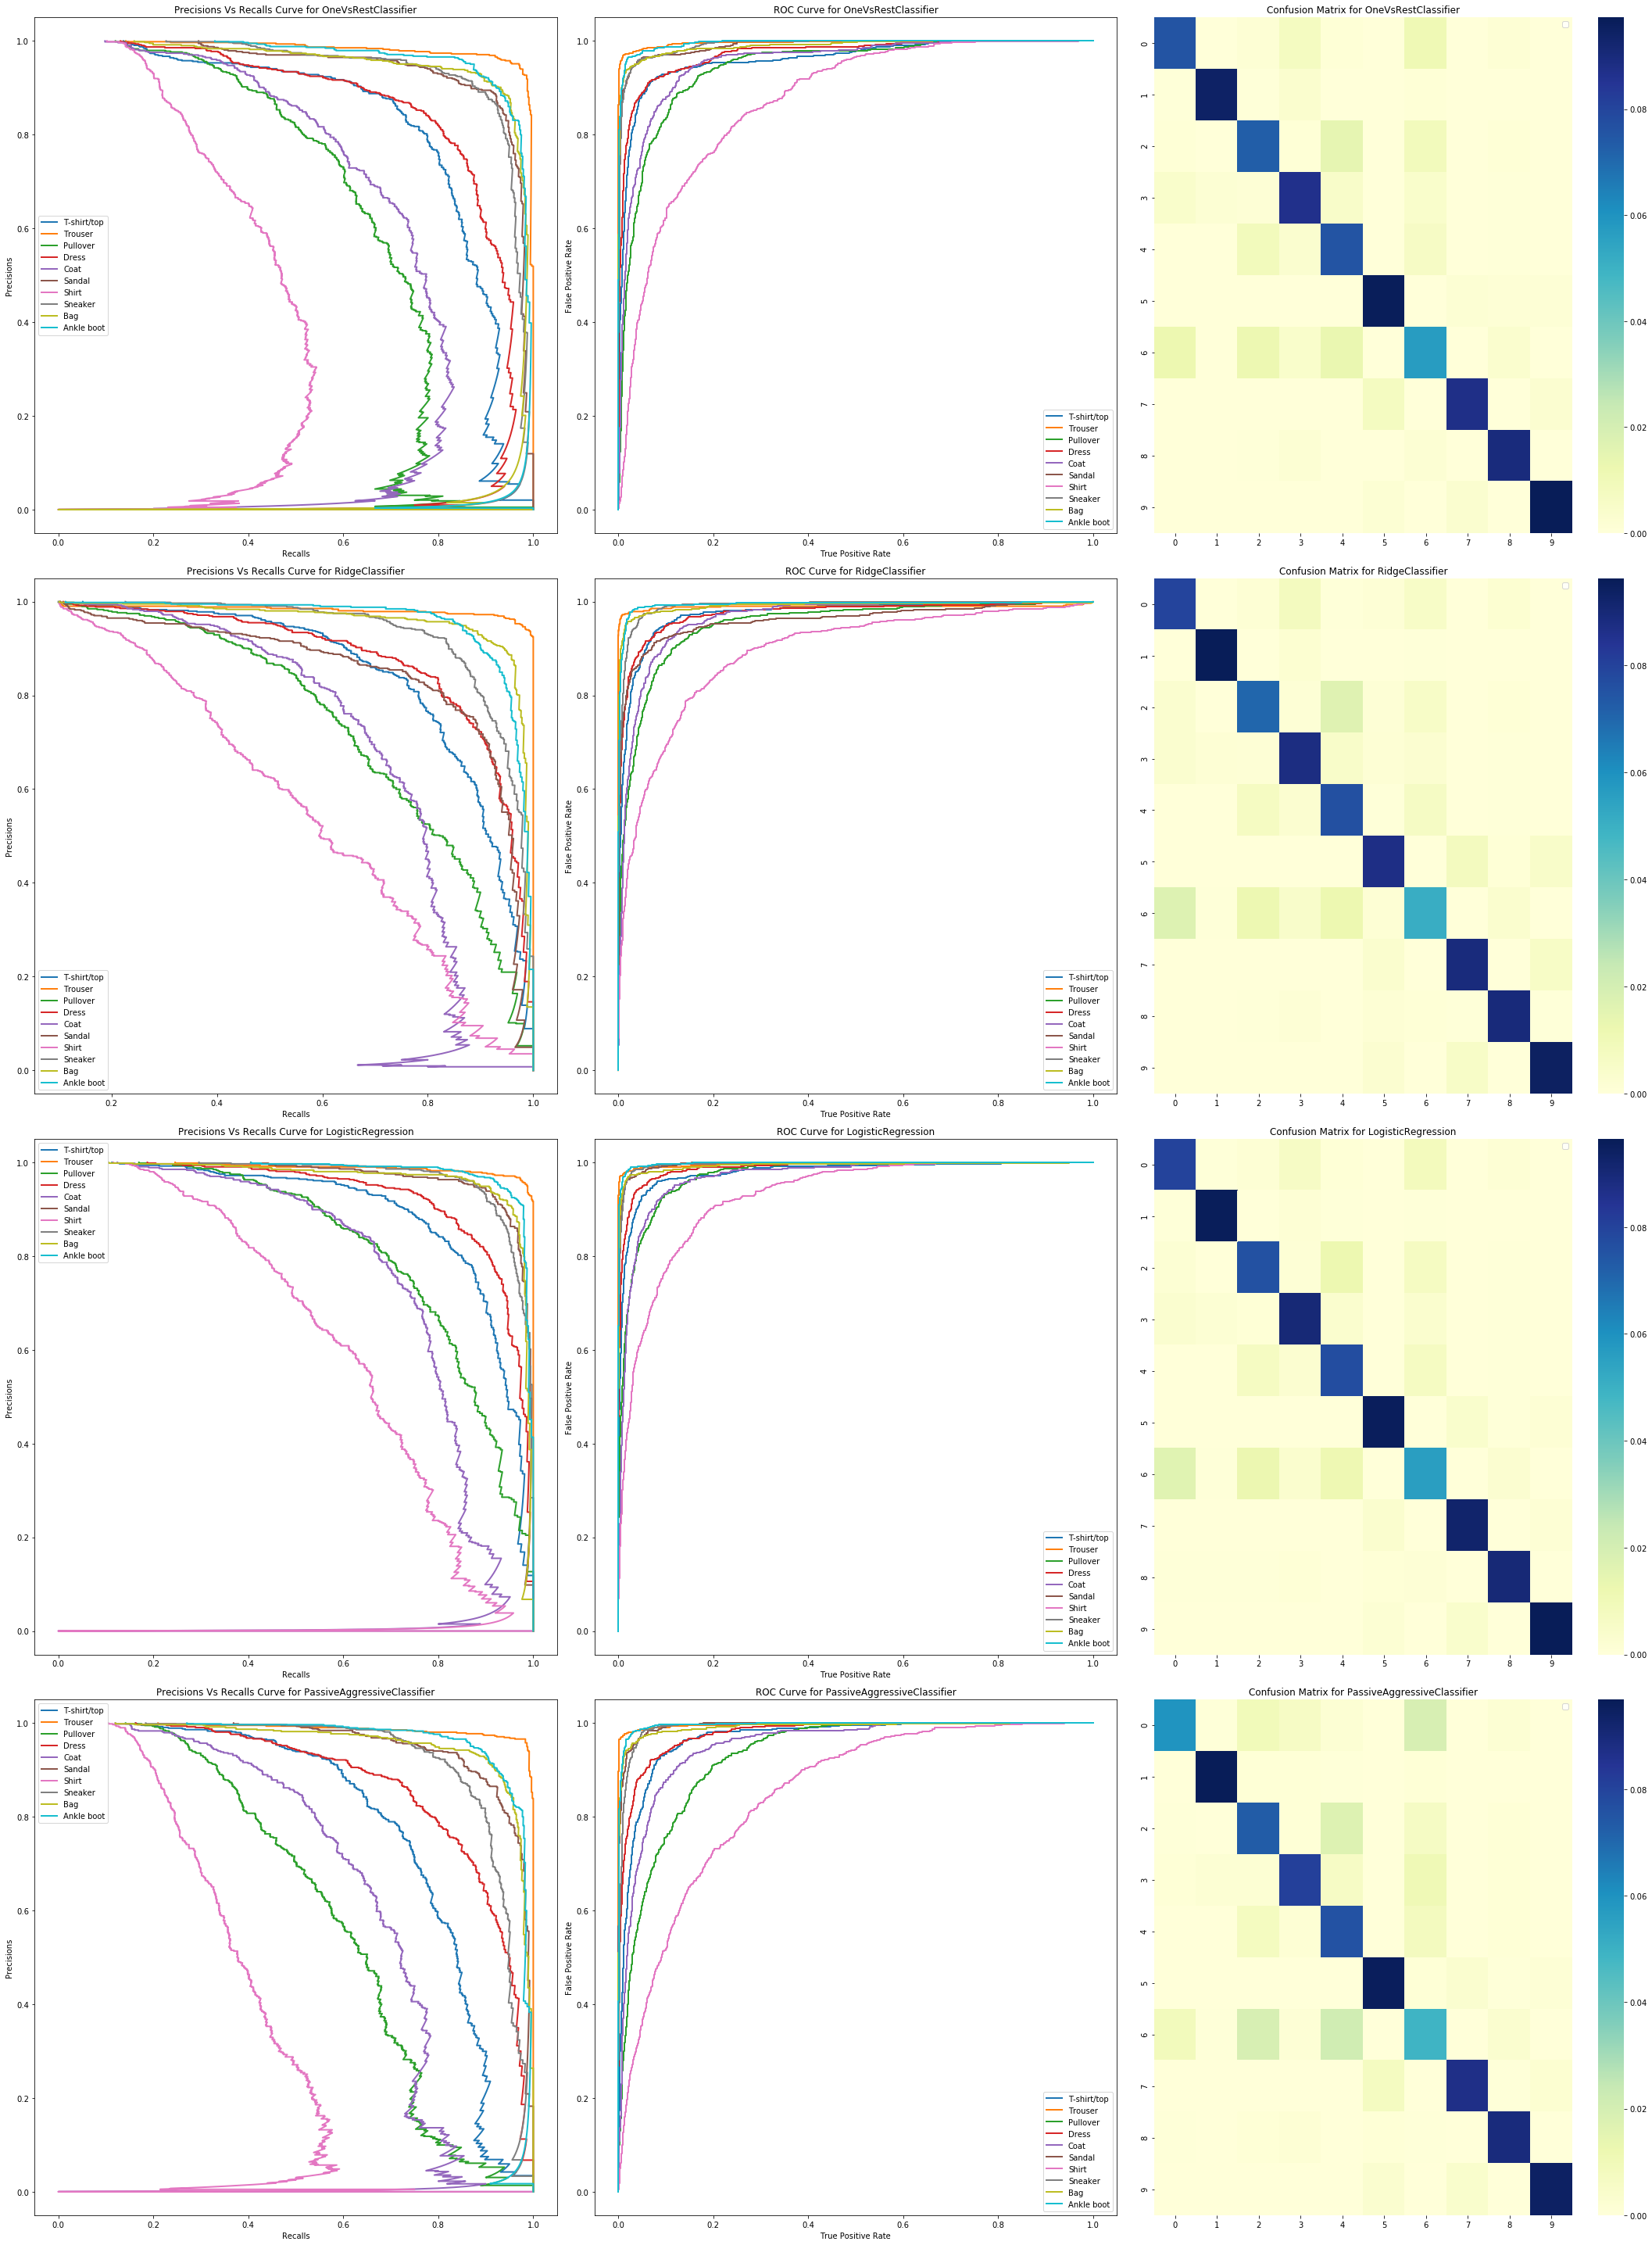

In [34]:
comparator.comparing()

In [35]:
# Now, non-linear, all default setting
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
knn_clf = KNeighborsClassifier()
#gp_clf = GaussianProcessClassifier(1.0 * RBF(1.0))
gnb_clf = GaussianNB()
qda_clf = QuadraticDiscriminantAnalysis()
non_linear_estimators = [knn_clf, gnb_clf, qda_clf]

In [36]:
comparator.set_estimators(non_linear_estimators)

Instantiating a model for KNeighborsClassifier estimator
Creating model evaluator for the model of KNeighborsClassifier
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


Instantiating a model for GaussianNB estimator
Creating model evaluator for the model of GaussianNB
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


Instantiating a model for QuadraticDiscriminantAnalysis estimator
Creating model evaluator for the model of QuadraticDiscriminantAnalysis
Calculating the cross validation scores


c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:716: RuntimeWarning: overflow encountered in square
  norm2.append(np.sum(X2 ** 2, 1))
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:716: RuntimeWarning: overflow encountered in square
  norm2.append(np.sum(X2 ** 2, 1))
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\3056986\appdata\local\progr

Calculating the confusion matrix


c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:716: RuntimeWarning: overflow encountered in square
  norm2.append(np.sum(X2 ** 2, 1))
No handles with labels found to put in legend.


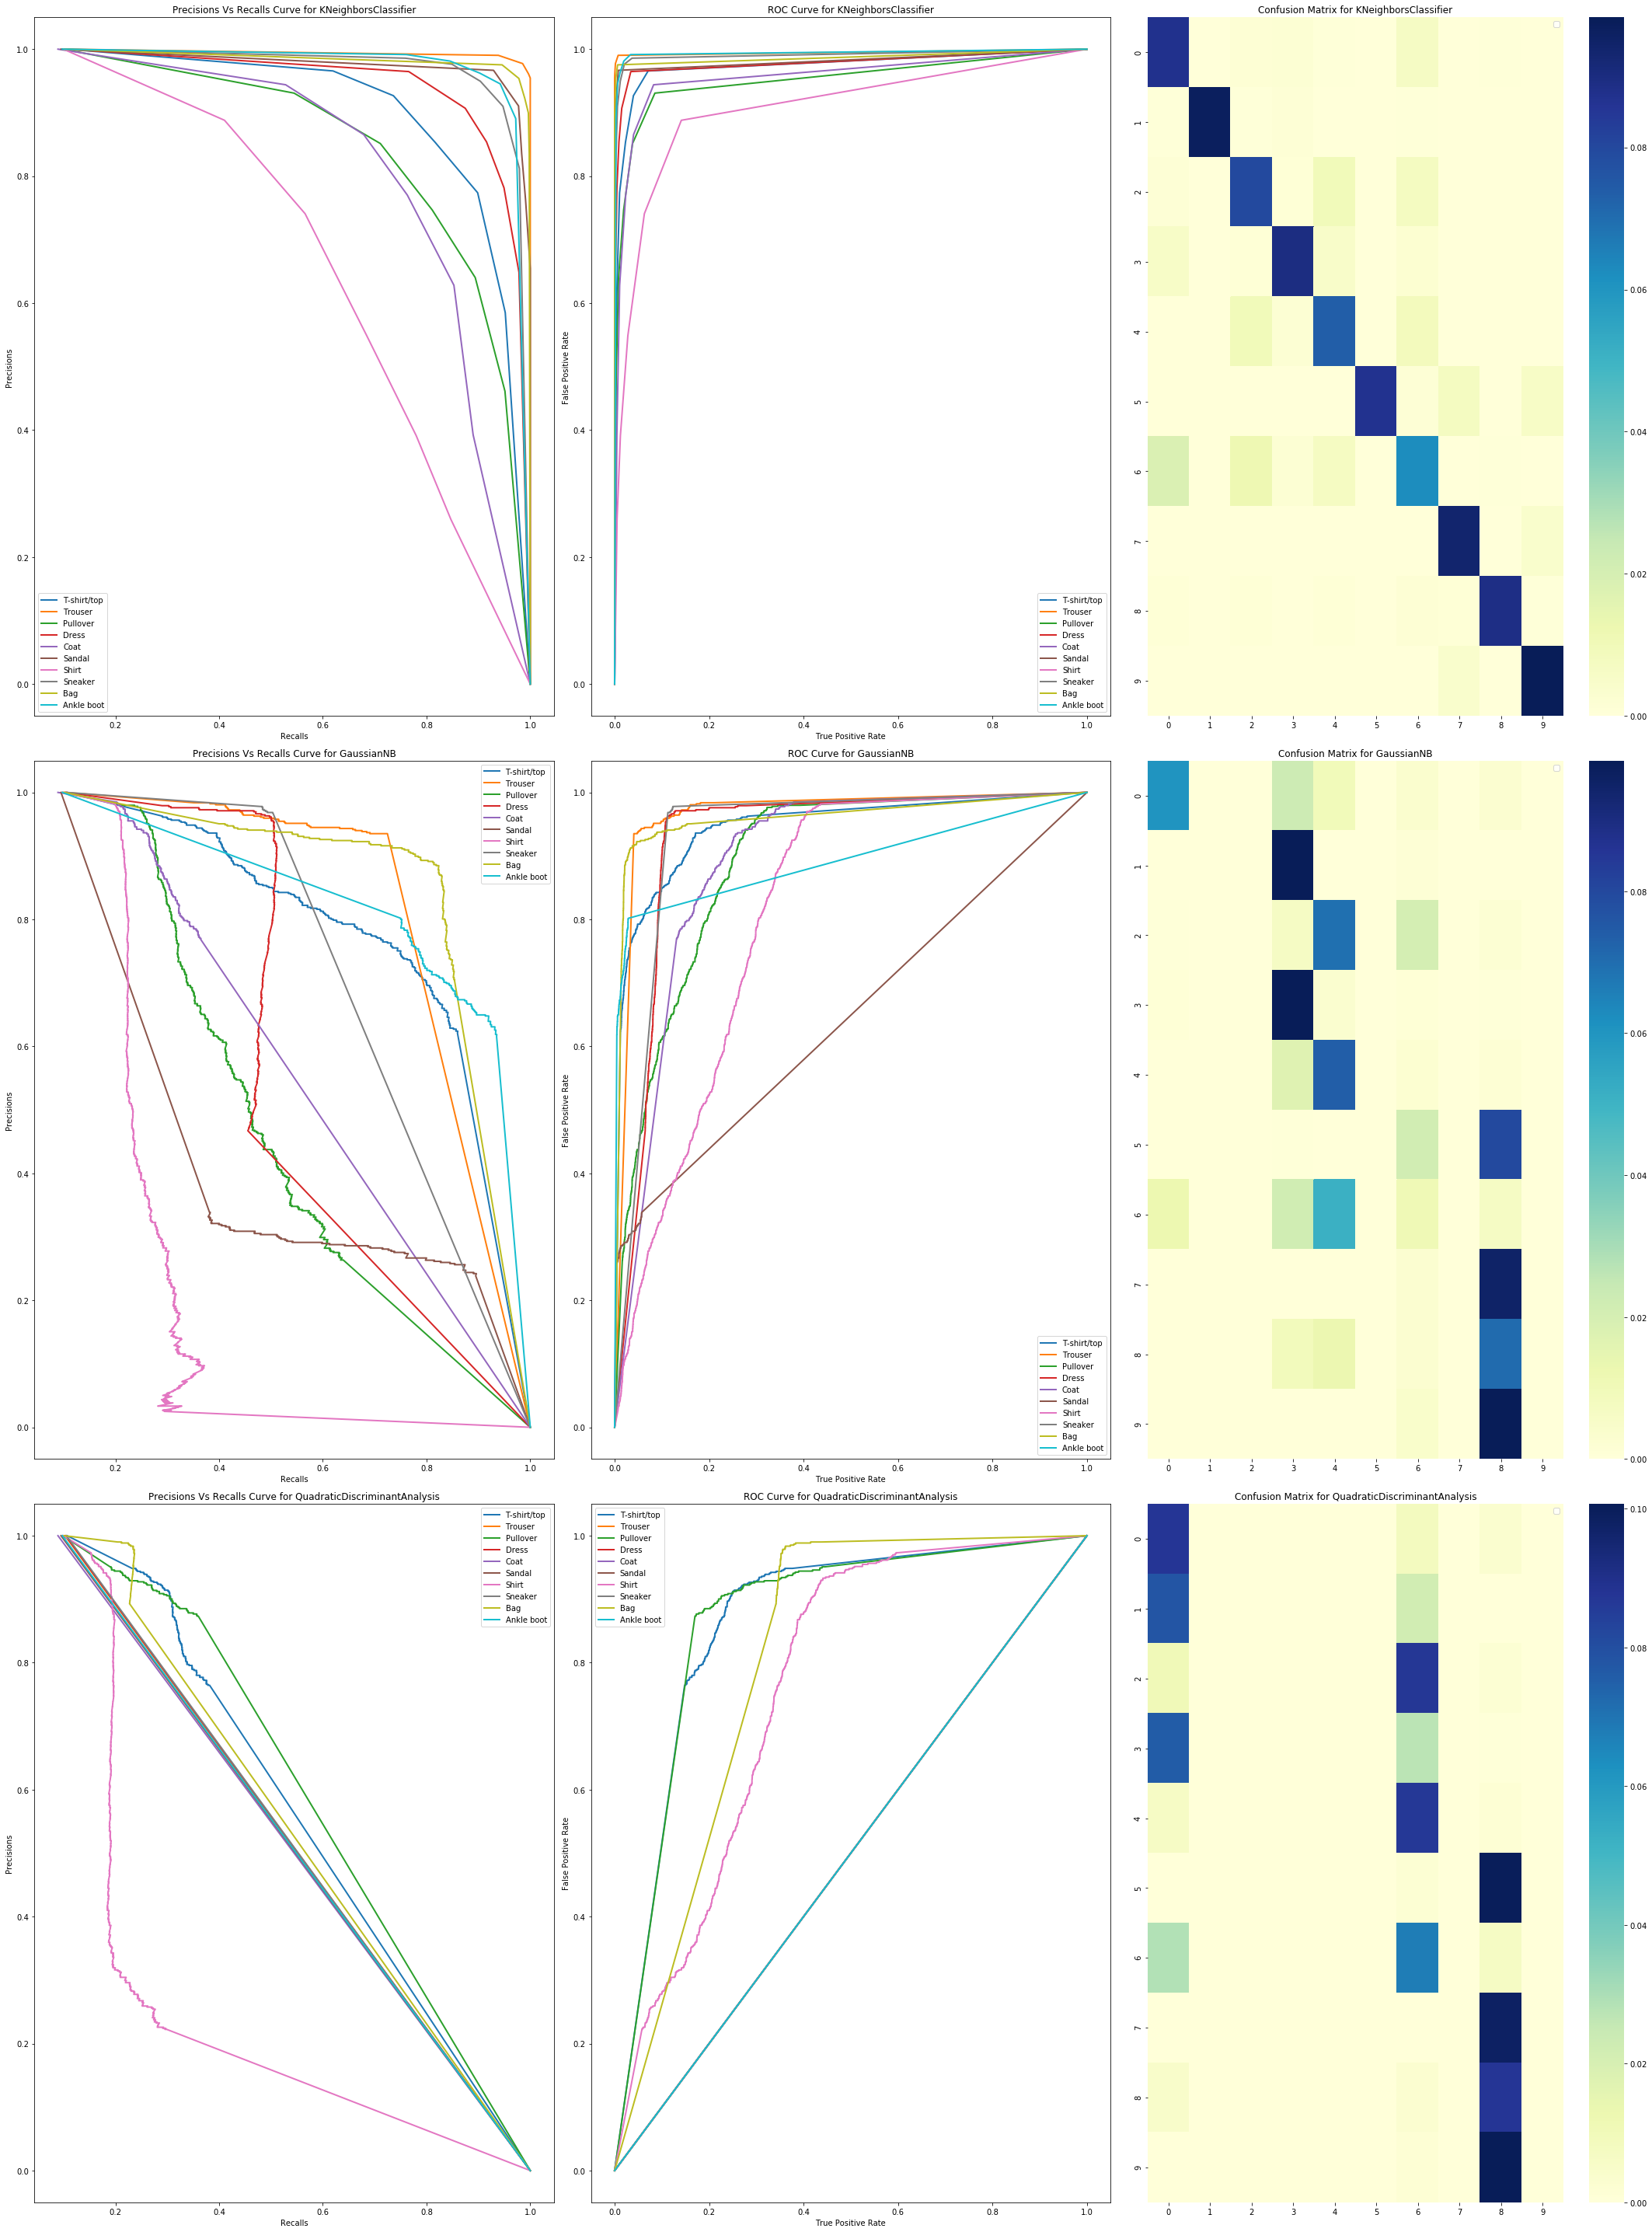

In [37]:
comparator.comparing()

In [131]:
# Trying the ensemble methods with all default settings
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
)
ada_clf = AdaBoostClassifier(random_state = 42)
bag_clf = BaggingClassifier(random_state = 42)
grad_boost_clf = GradientBoostingClassifier(random_state = 42)
rdf_clf = RandomForestClassifier(random_state = 42)

In [39]:
ensembles = [ada_clf, bag_clf, grad_boost_clf, rdf_clf]
comparator.set_estimators(ensembles)

Instantiating a model for AdaBoostClassifier estimator
Creating model evaluator for the model of AdaBoostClassifier
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


Instantiating a model for BaggingClassifier estimator
Creating model evaluator for the model of BaggingClassifier
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


Instantiating a model for GradientBoostingClassifier estimator
Creating model evaluator for the model of GradientBoostingClassifier
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


Instantiating a model for RandomForestClassifier estimator
Creating model evaluator for the model of RandomForestClassifier
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


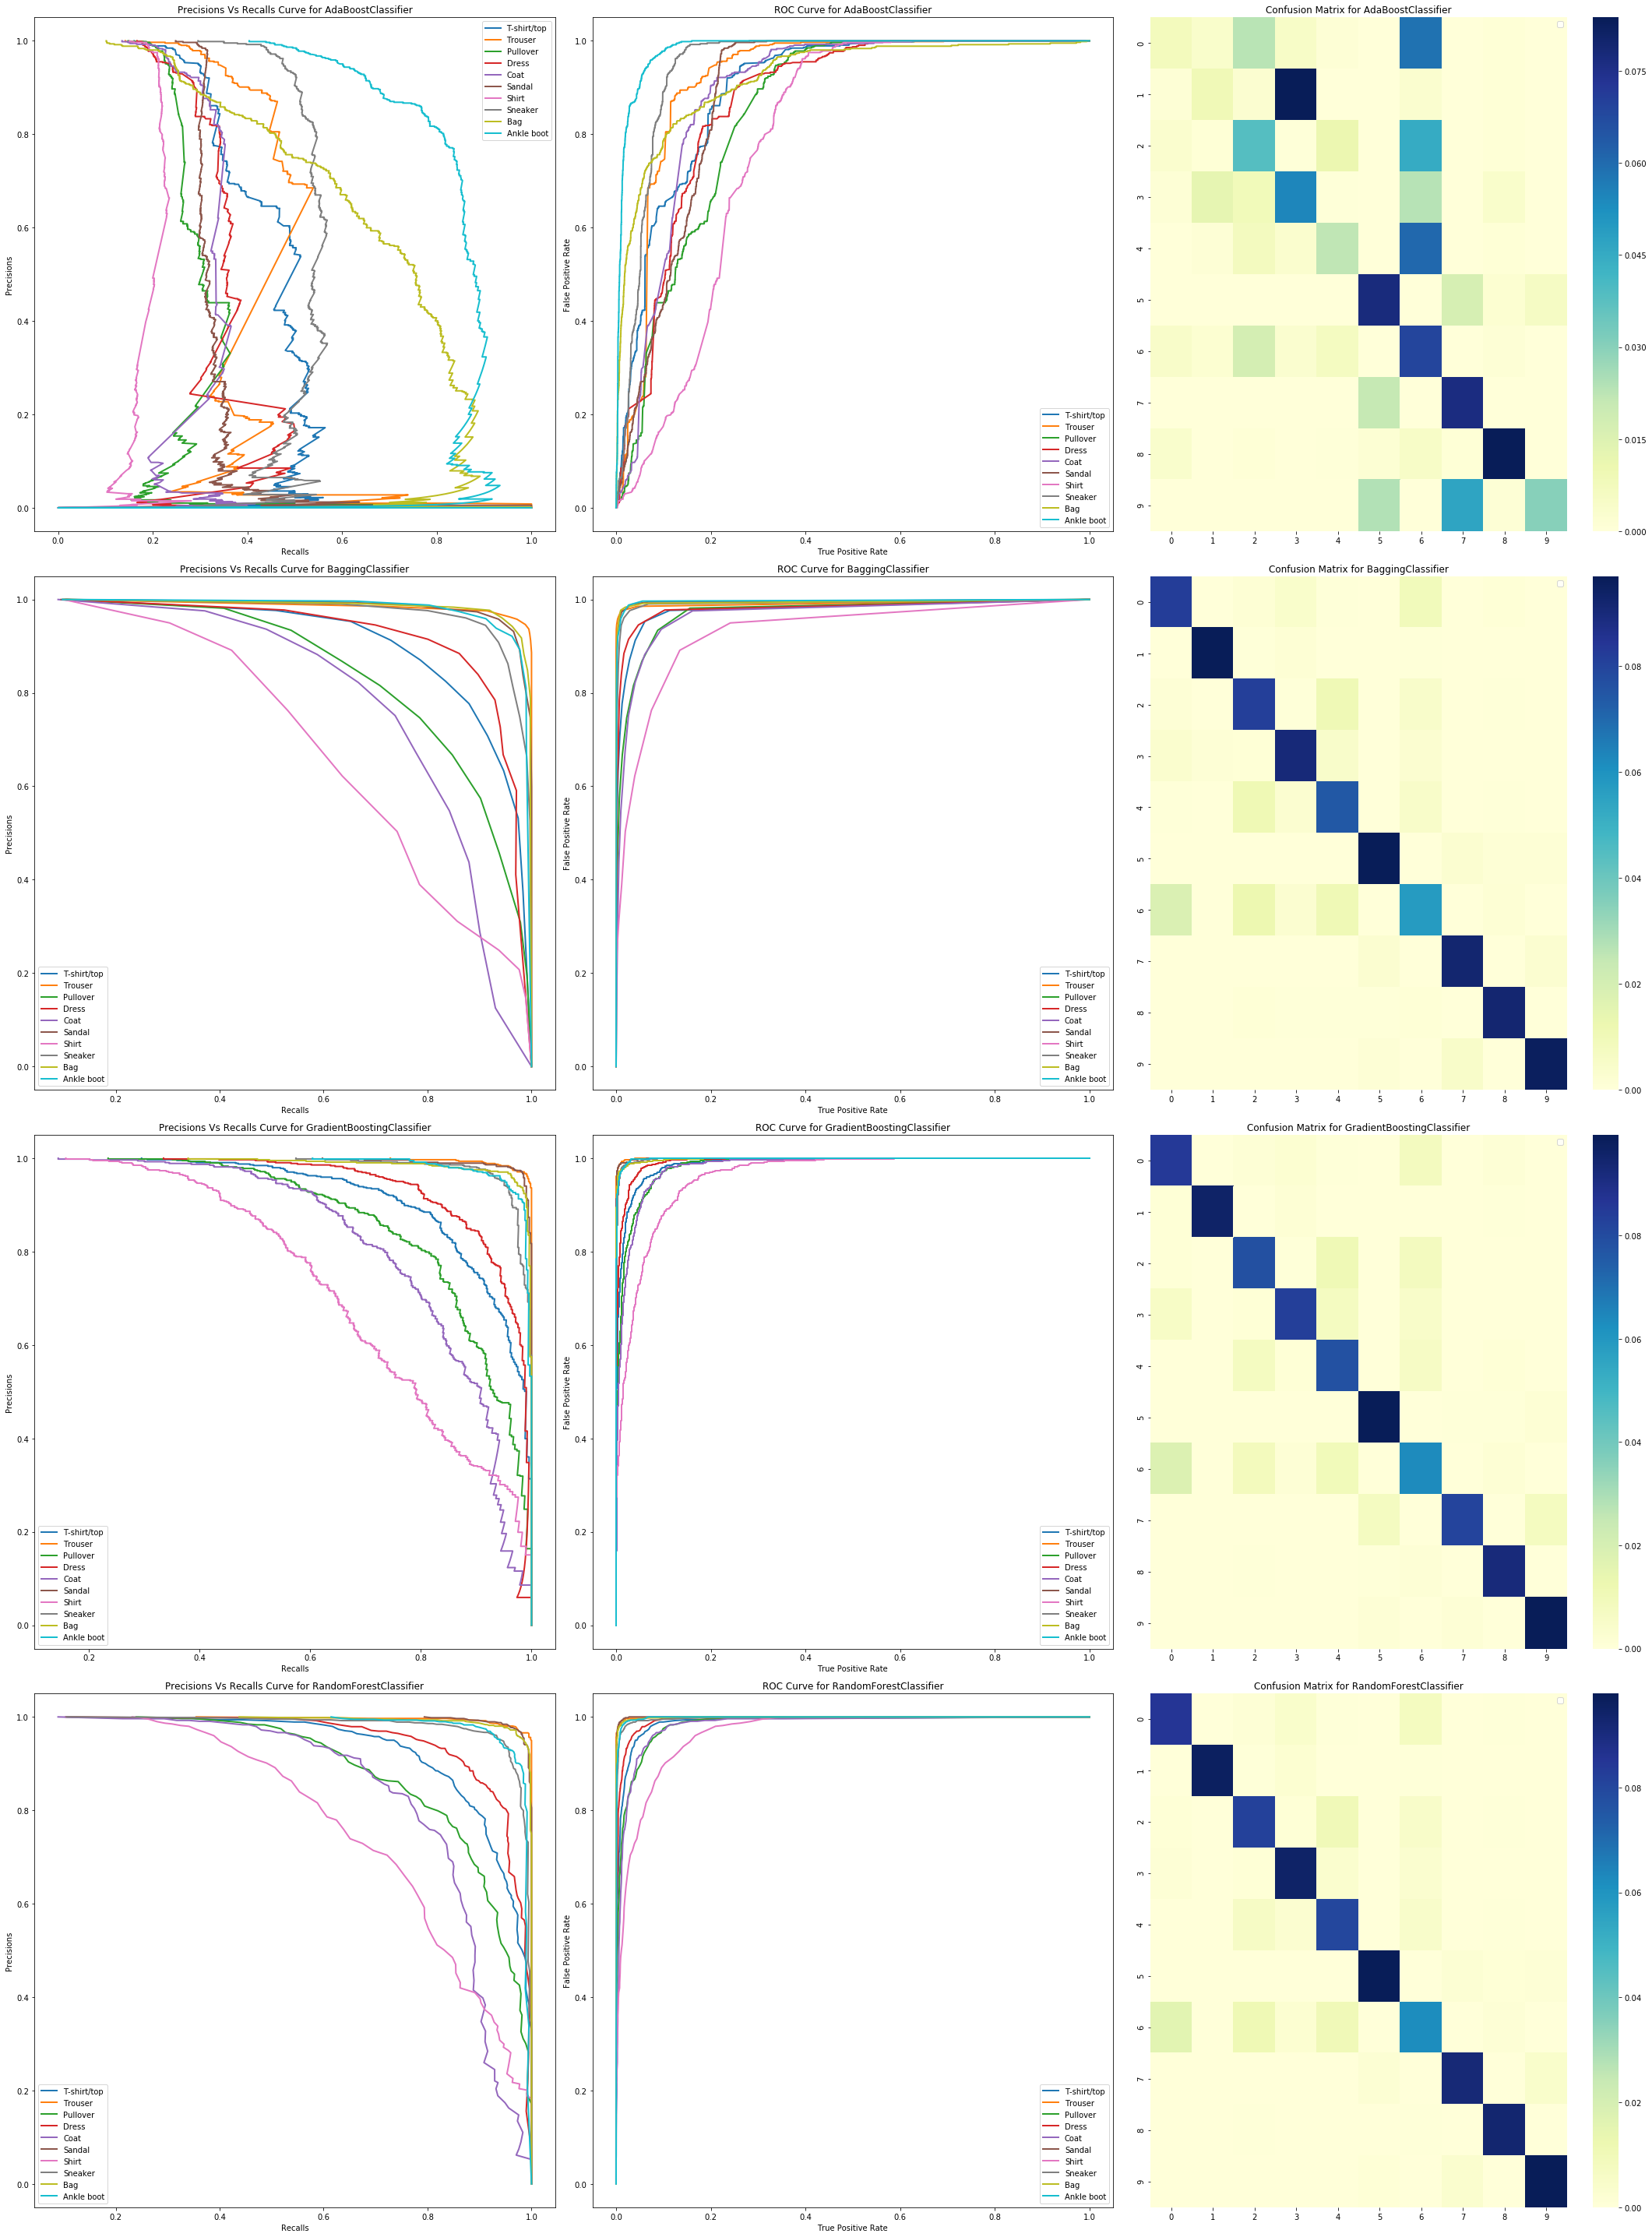

In [40]:
comparator.comparing()

In [88]:
# According to previous comparisions, we can form a voting classifier using the following classifiers:
# RidgeClassifier, LogisticRegressor, KNeighborsClassifier, RandomForestClassifier
from sklearn.ensemble import VotingClassifier
voters = [('log_clf', log_reg_clf), ('knn_clf', knn_clf), ('rdf_clf', rdf_clf)]
voting_clf = VotingClassifier(estimators = voters, voting = 'soft', n_jobs = -1)
final_estimators = [log_reg_clf, knn_clf, rdf_clf, voting_clf]

In [90]:
comparator.set_estimators(final_estimators)

Instantiating a model for LogisticRegression estimator
Creating model evaluator for the model of LogisticRegression
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


Instantiating a model for KNeighborsClassifier estimator
Creating model evaluator for the model of KNeighborsClassifier
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


Instantiating a model for RandomForestClassifier estimator
Creating model evaluator for the model of RandomForestClassifier
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


Instantiating a model for VotingClassifier estimator
Creating model evaluator for the model of VotingClassifier
Calculating the cross validation scores


c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\joblib\disk.py:120: UserWarning: Unable to delete folder C:\Users\3056986\AppData\Local\Temp\joblib_memmapping_folder_8348_1462024952 after 5 tentatives.
  warnings.warn(


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\3056986\\AppData\\Local\\Temp\\joblib_memmapping_folder_8348_1462024952\\8348-2485280810128-64d82f345867458ea82c205e246f4e8a.pkl'

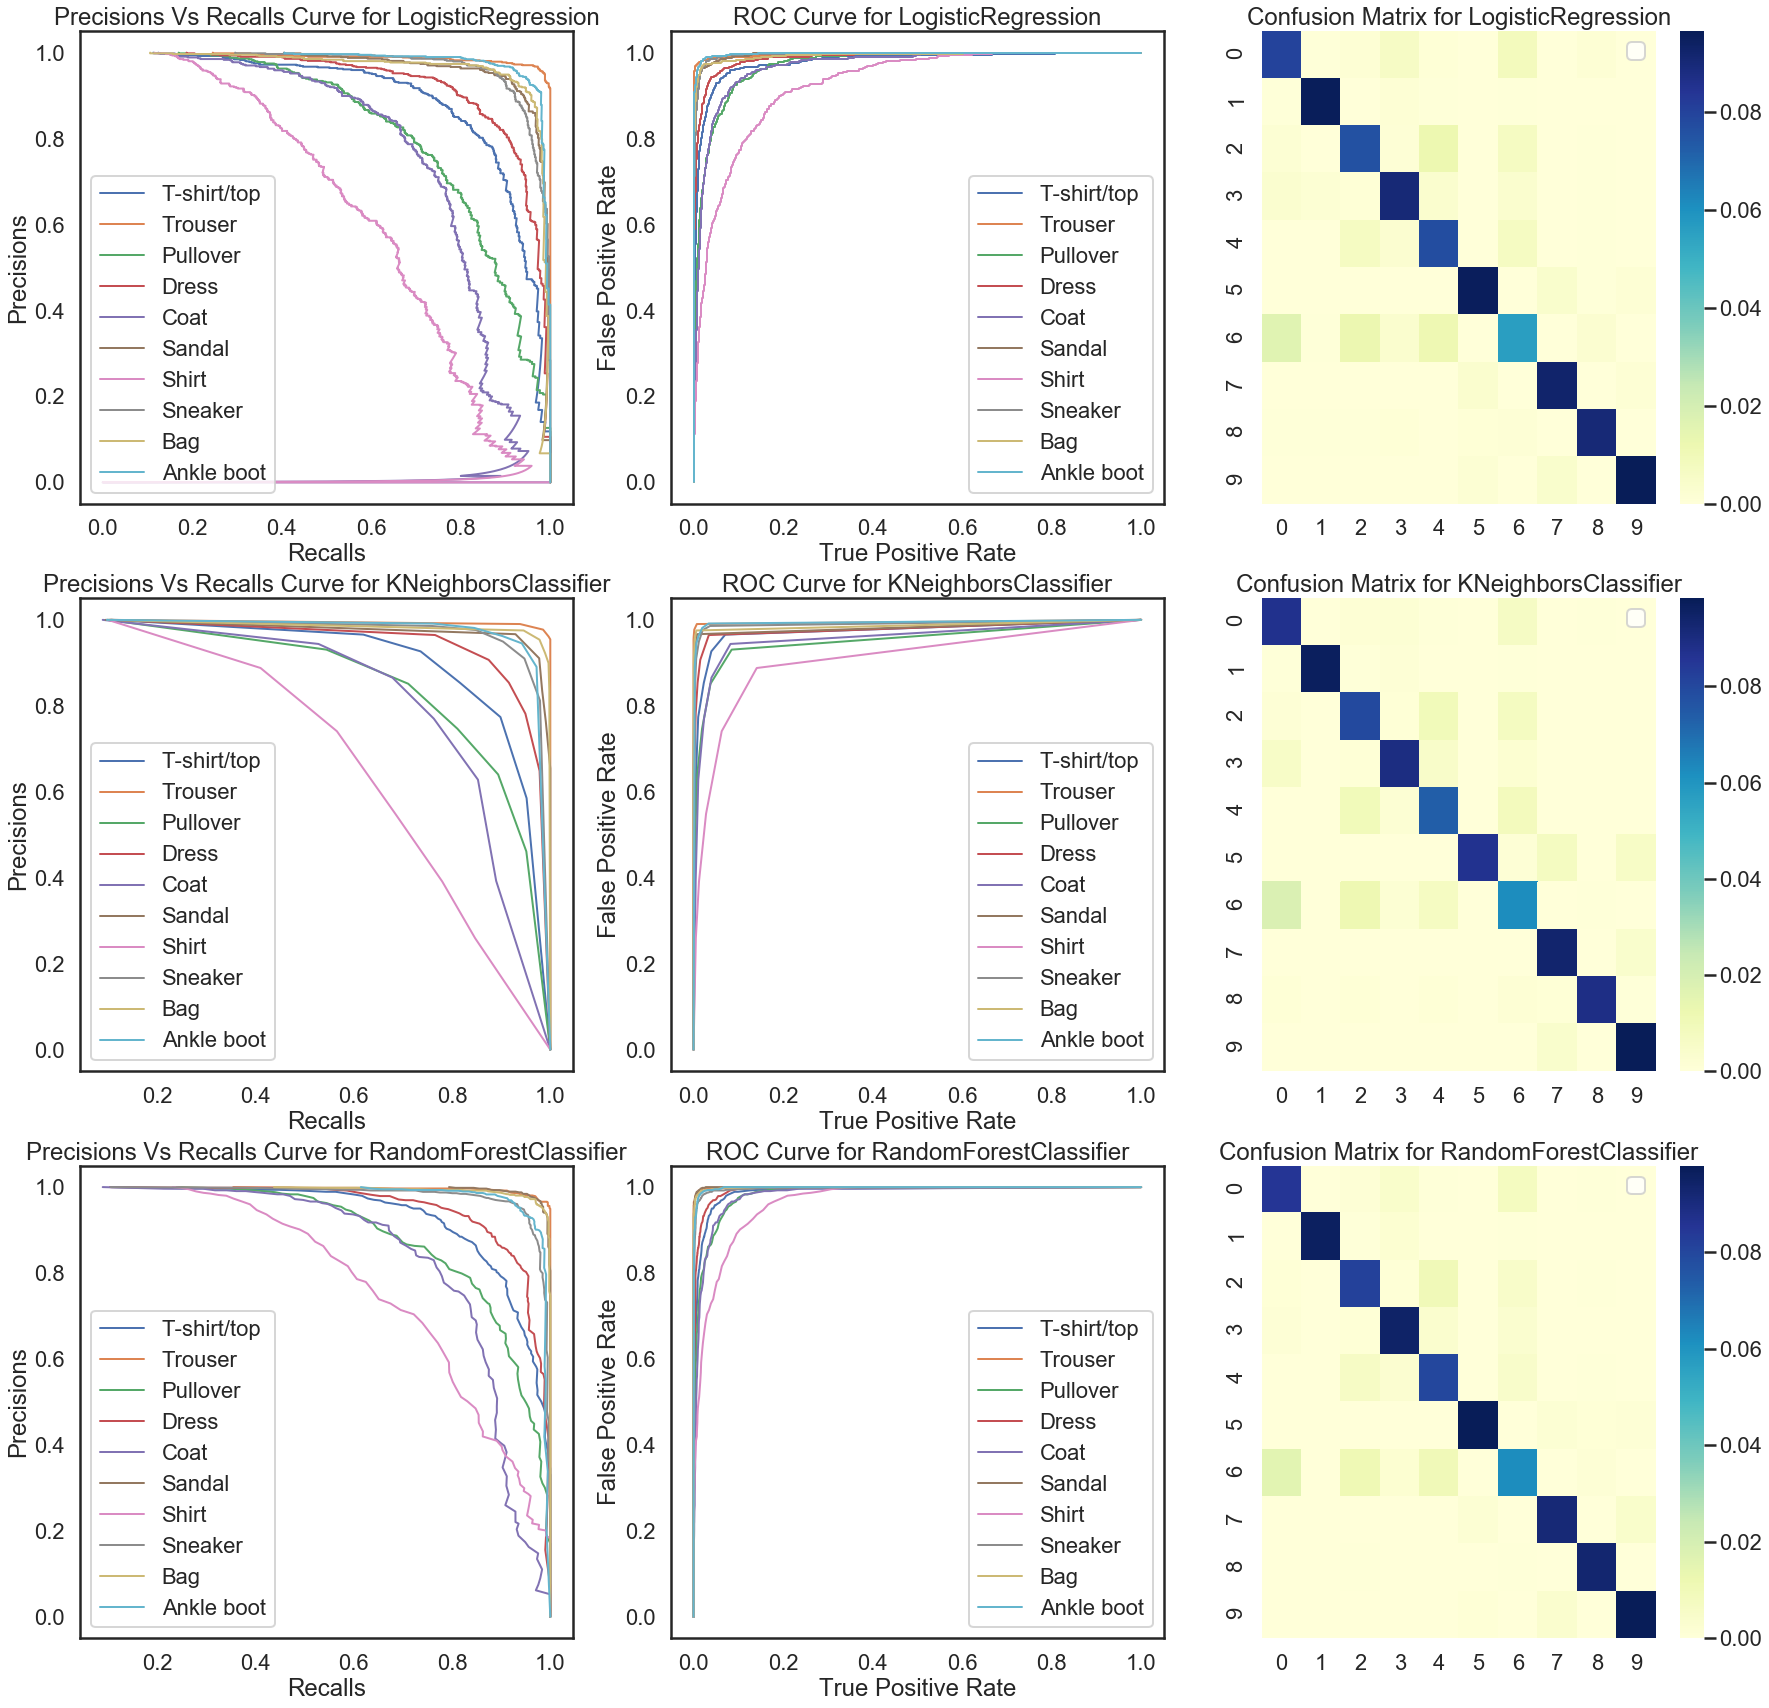

In [91]:
comparator.comparing()

-------------------------Description-----------------------------

**Author**: Han Xiao, Kashif Rasul, Roland Vollgraf  
**Source**: [Zalando Research](https://github.com/zalandoresearch/fashion-mnist)  
**Please cite**: Han Xiao and Kashif Rasul and Roland Vollgraf, Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms, arXiv, cs.LG/1708.07747  

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. 

Raw data available at: https://github.com/zalandoresearch/fashion-mnist

### Target classes
Each training and test example is assigned to one of the following labels:
Label  Descr

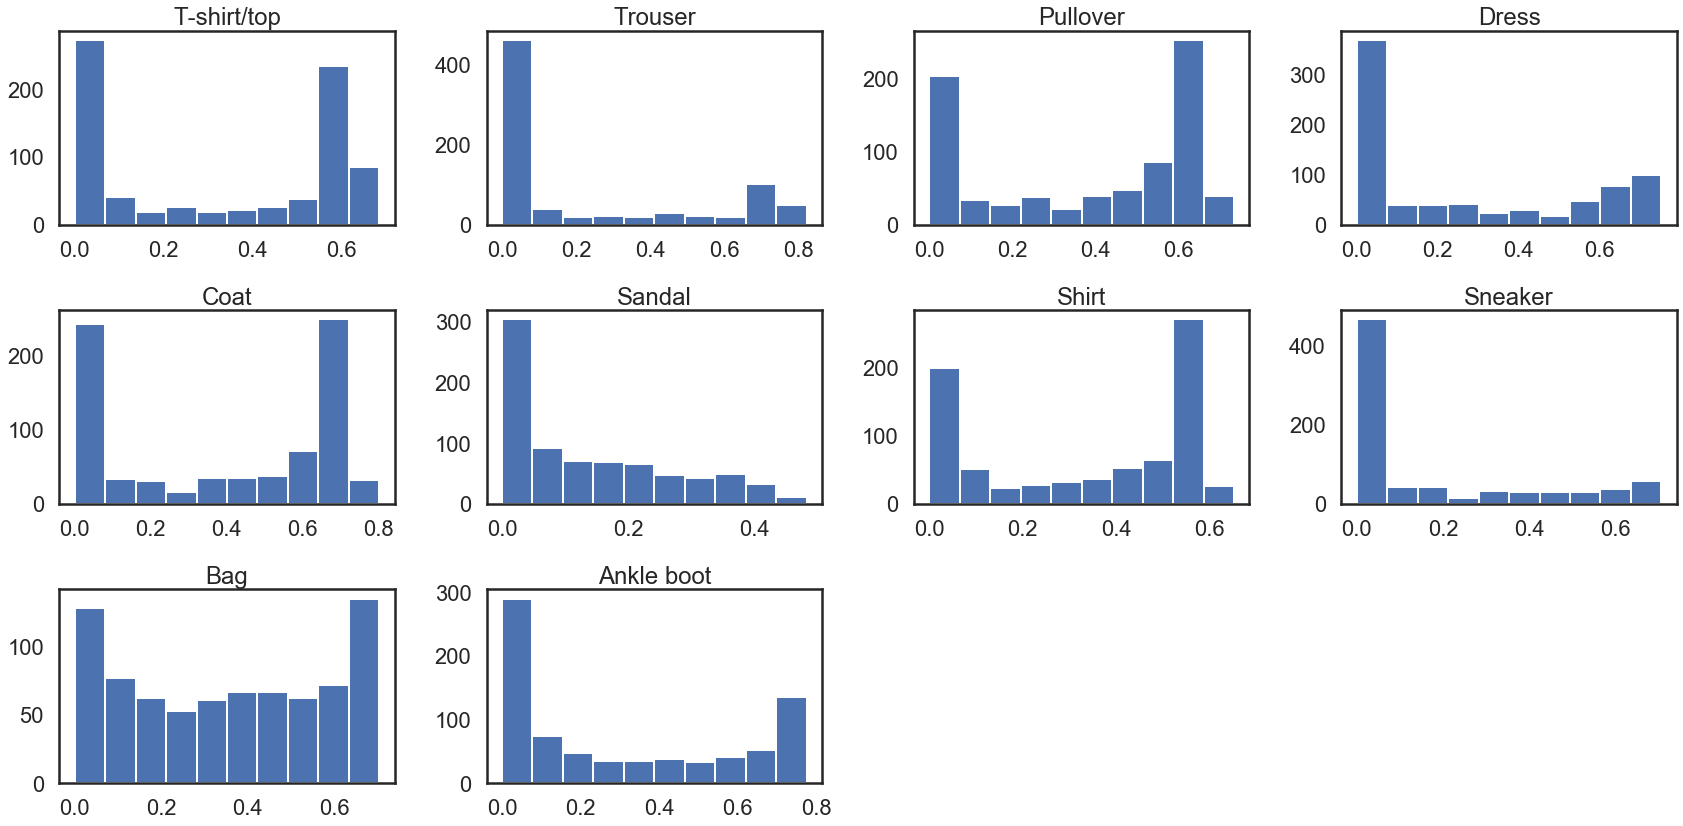

In [67]:
from sklearn.decomposition import PCA
fashion = PrepaData()
fashion_data = fashion.get_data()
fig_two = plt.figure(figsize = (24, 12))
fashion.color_distribution(fig_two, fashion_data, 3, 28)

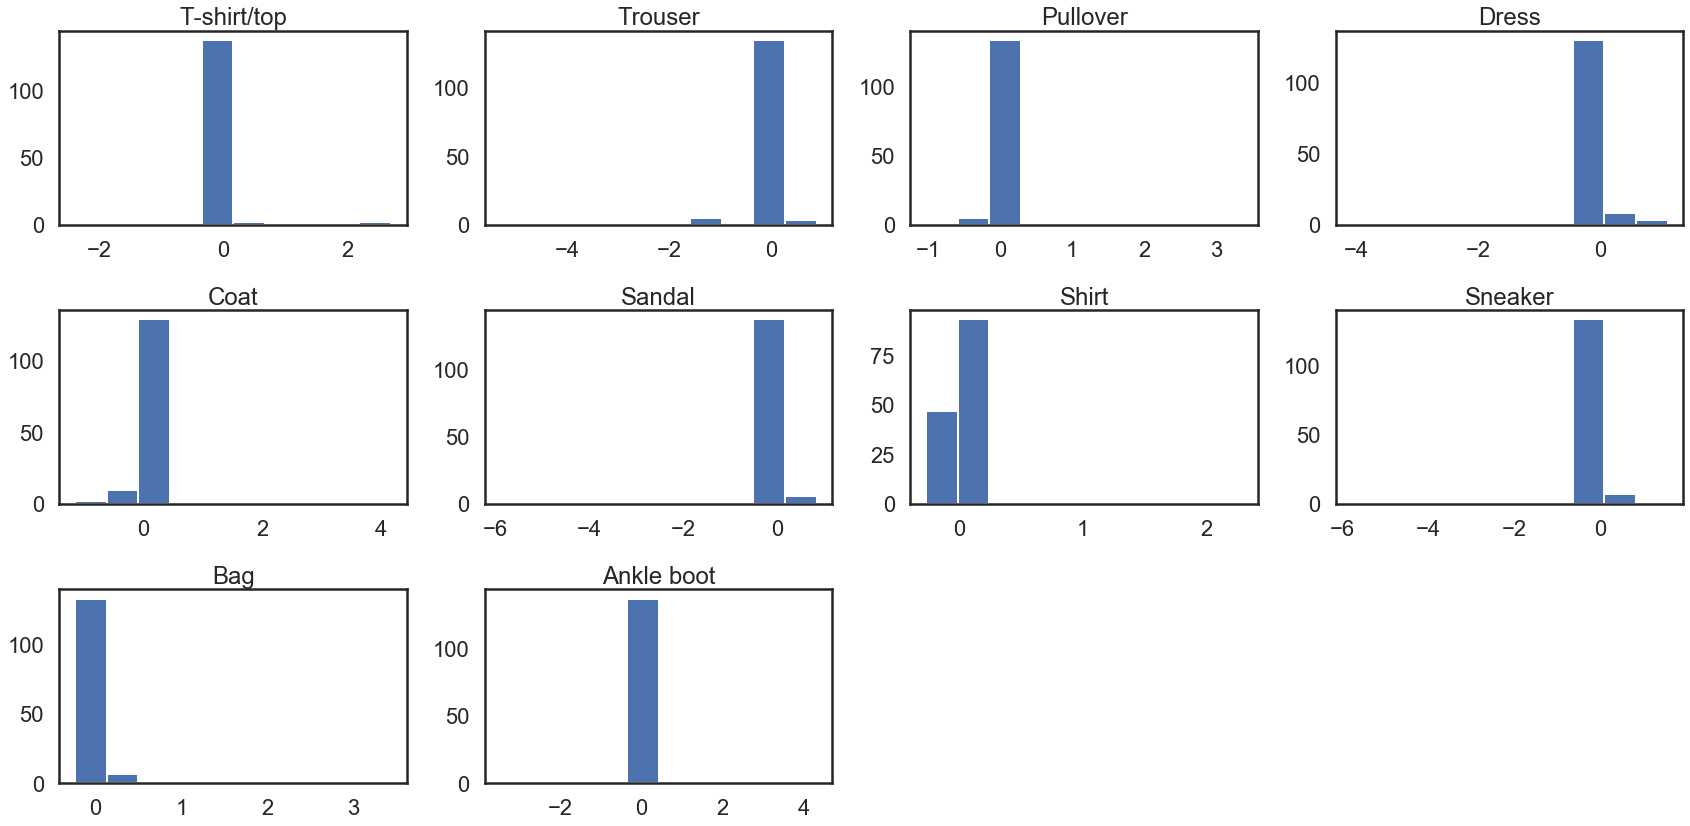

In [68]:
pca = PCA(n_components = 144)
lower_dimension = pca.fit_transform(fashion_data)
fig_three = plt.figure(figsize = (24, 12))
fashion.color_distribution(fig_three, lower_dimension, 3, 12)

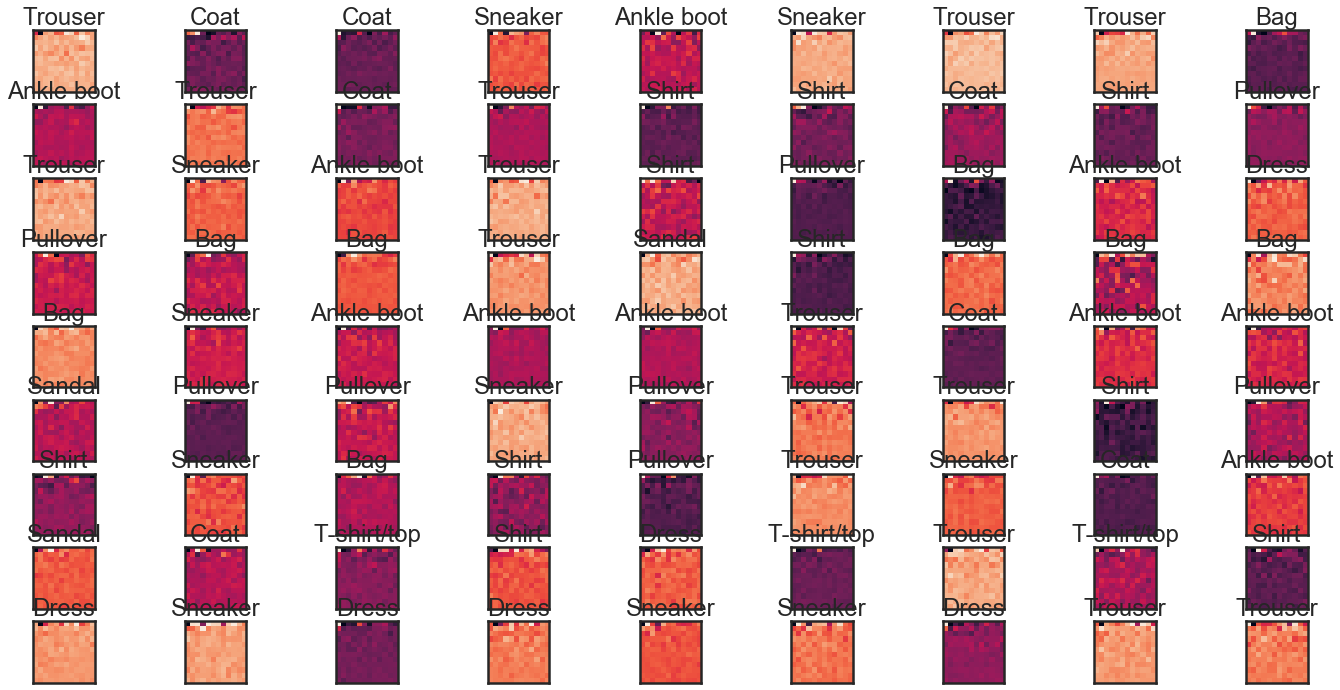

In [69]:
fig_four = plt.figure(figsize = (24, 12))
clothing.show_img(fig_four, lower_dimension, example_indices, 9, 9, 12)

-------------------------Description-----------------------------

**Author**: Han Xiao, Kashif Rasul, Roland Vollgraf  
**Source**: [Zalando Research](https://github.com/zalandoresearch/fashion-mnist)  
**Please cite**: Han Xiao and Kashif Rasul and Roland Vollgraf, Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms, arXiv, cs.LG/1708.07747  

Fashion-MNIST is a dataset of Zalando's article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Fashion-MNIST is intended to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits. 

Raw data available at: https://github.com/zalandoresearch/fashion-mnist

### Target classes
Each training and test example is assigned to one of the following labels:
Label  Descr

c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:554: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:554: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:554: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
c:\users\3056986\appdata\local\programs\python\python38\lib\site-pa

Calculating the confusion matrix


No handles with labels found to put in legend.


Creating a model for RidgeClassifier
Setting model evaluator for the model of RidgeClassifier
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


Creating a model for LogisticRegression
Setting model evaluator for the model of LogisticRegression
Calculating the cross validation scores


c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Calculating the confusion matrix


No handles with labels found to put in legend.


Creating a model for PassiveAggressiveClassifier
Setting model evaluator for the model of PassiveAggressiveClassifier
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


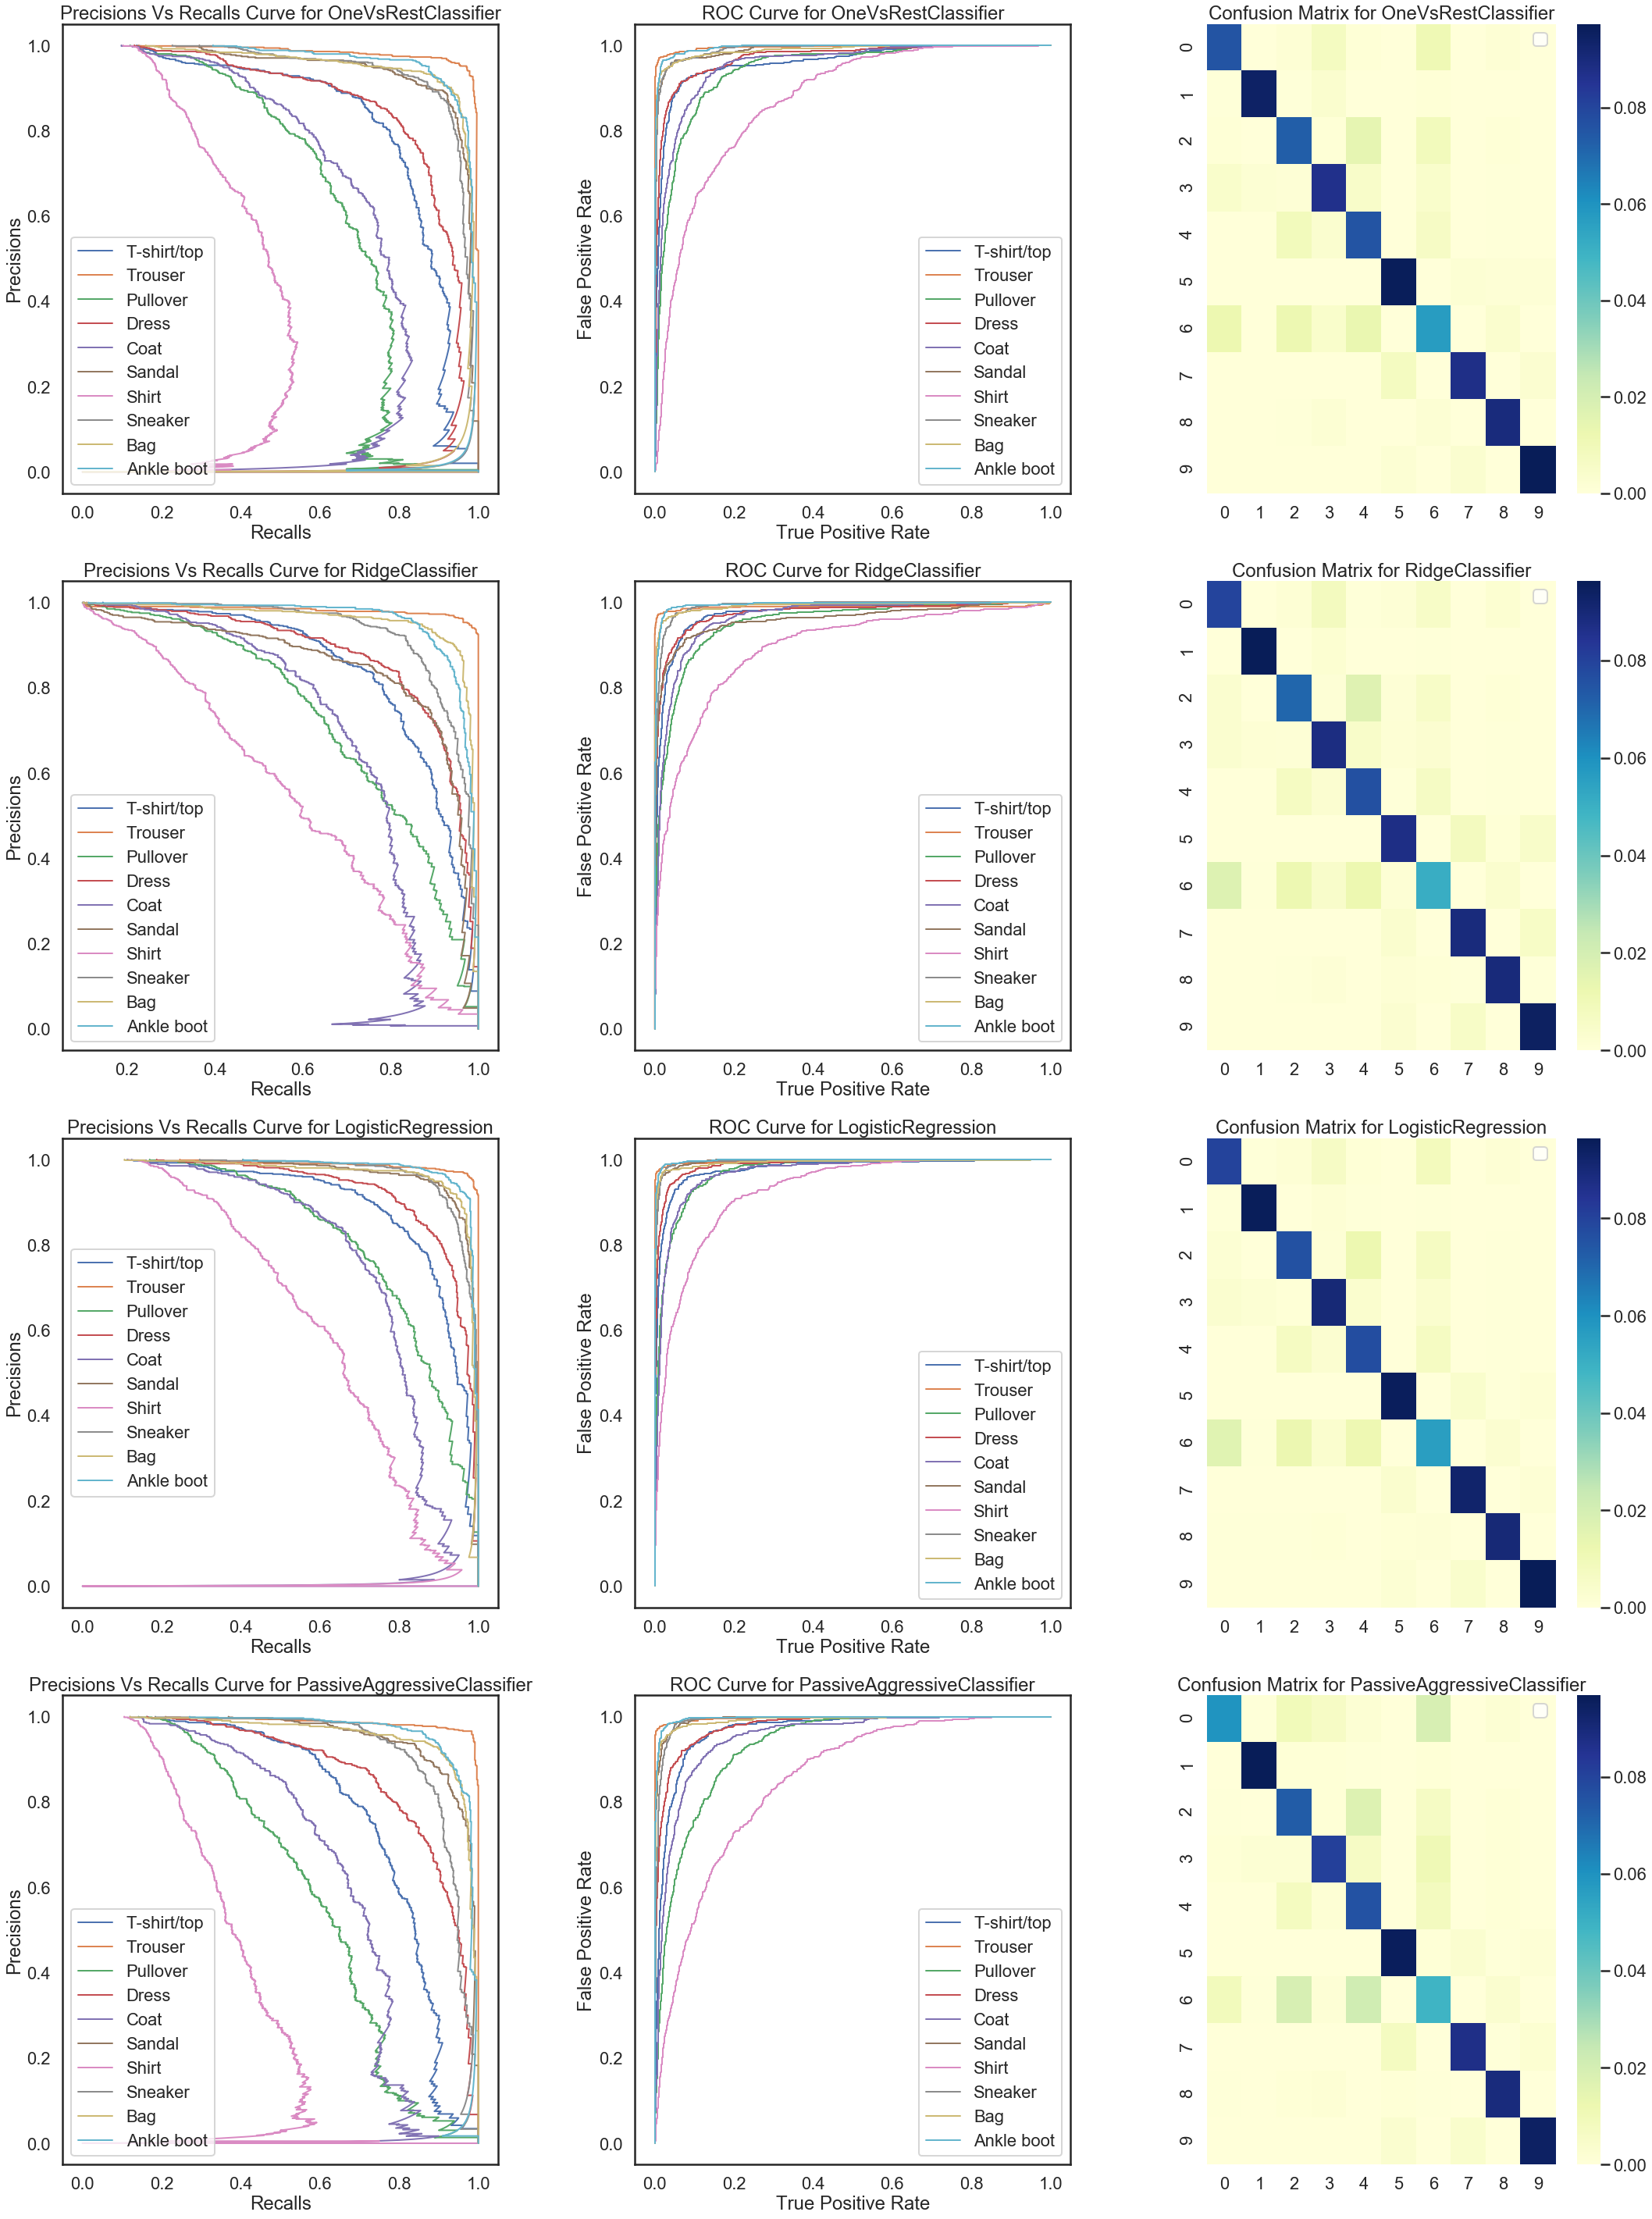

In [133]:
# Generating a new comparator for lower dimension dataset
comparator_lowdim = Comparator('lowdim')
comparator_lowdim.set_dataset(lower_dimension)
comparator_lowdim.set_estimators(linear_estimators)
comparator_lowdim.comparing()

Creating a model for KNeighborsClassifier
Setting model evaluator for the model of KNeighborsClassifier
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


Creating a model for GaussianNB
Setting model evaluator for the model of GaussianNB
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


Creating a model for QuadraticDiscriminantAnalysis
Setting model evaluator for the model of QuadraticDiscriminantAnalysis
Calculating the cross validation scores


c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:716: RuntimeWarning: overflow encountered in square
  norm2.append(np.sum(X2 ** 2, 1))
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:716: RuntimeWarning: overflow encountered in square
  norm2.append(np.sum(X2 ** 2, 1))
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\users\3056986\appdata\local\progr

Calculating the confusion matrix


c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\discriminant_analysis.py:716: RuntimeWarning: overflow encountered in square
  norm2.append(np.sum(X2 ** 2, 1))
No handles with labels found to put in legend.


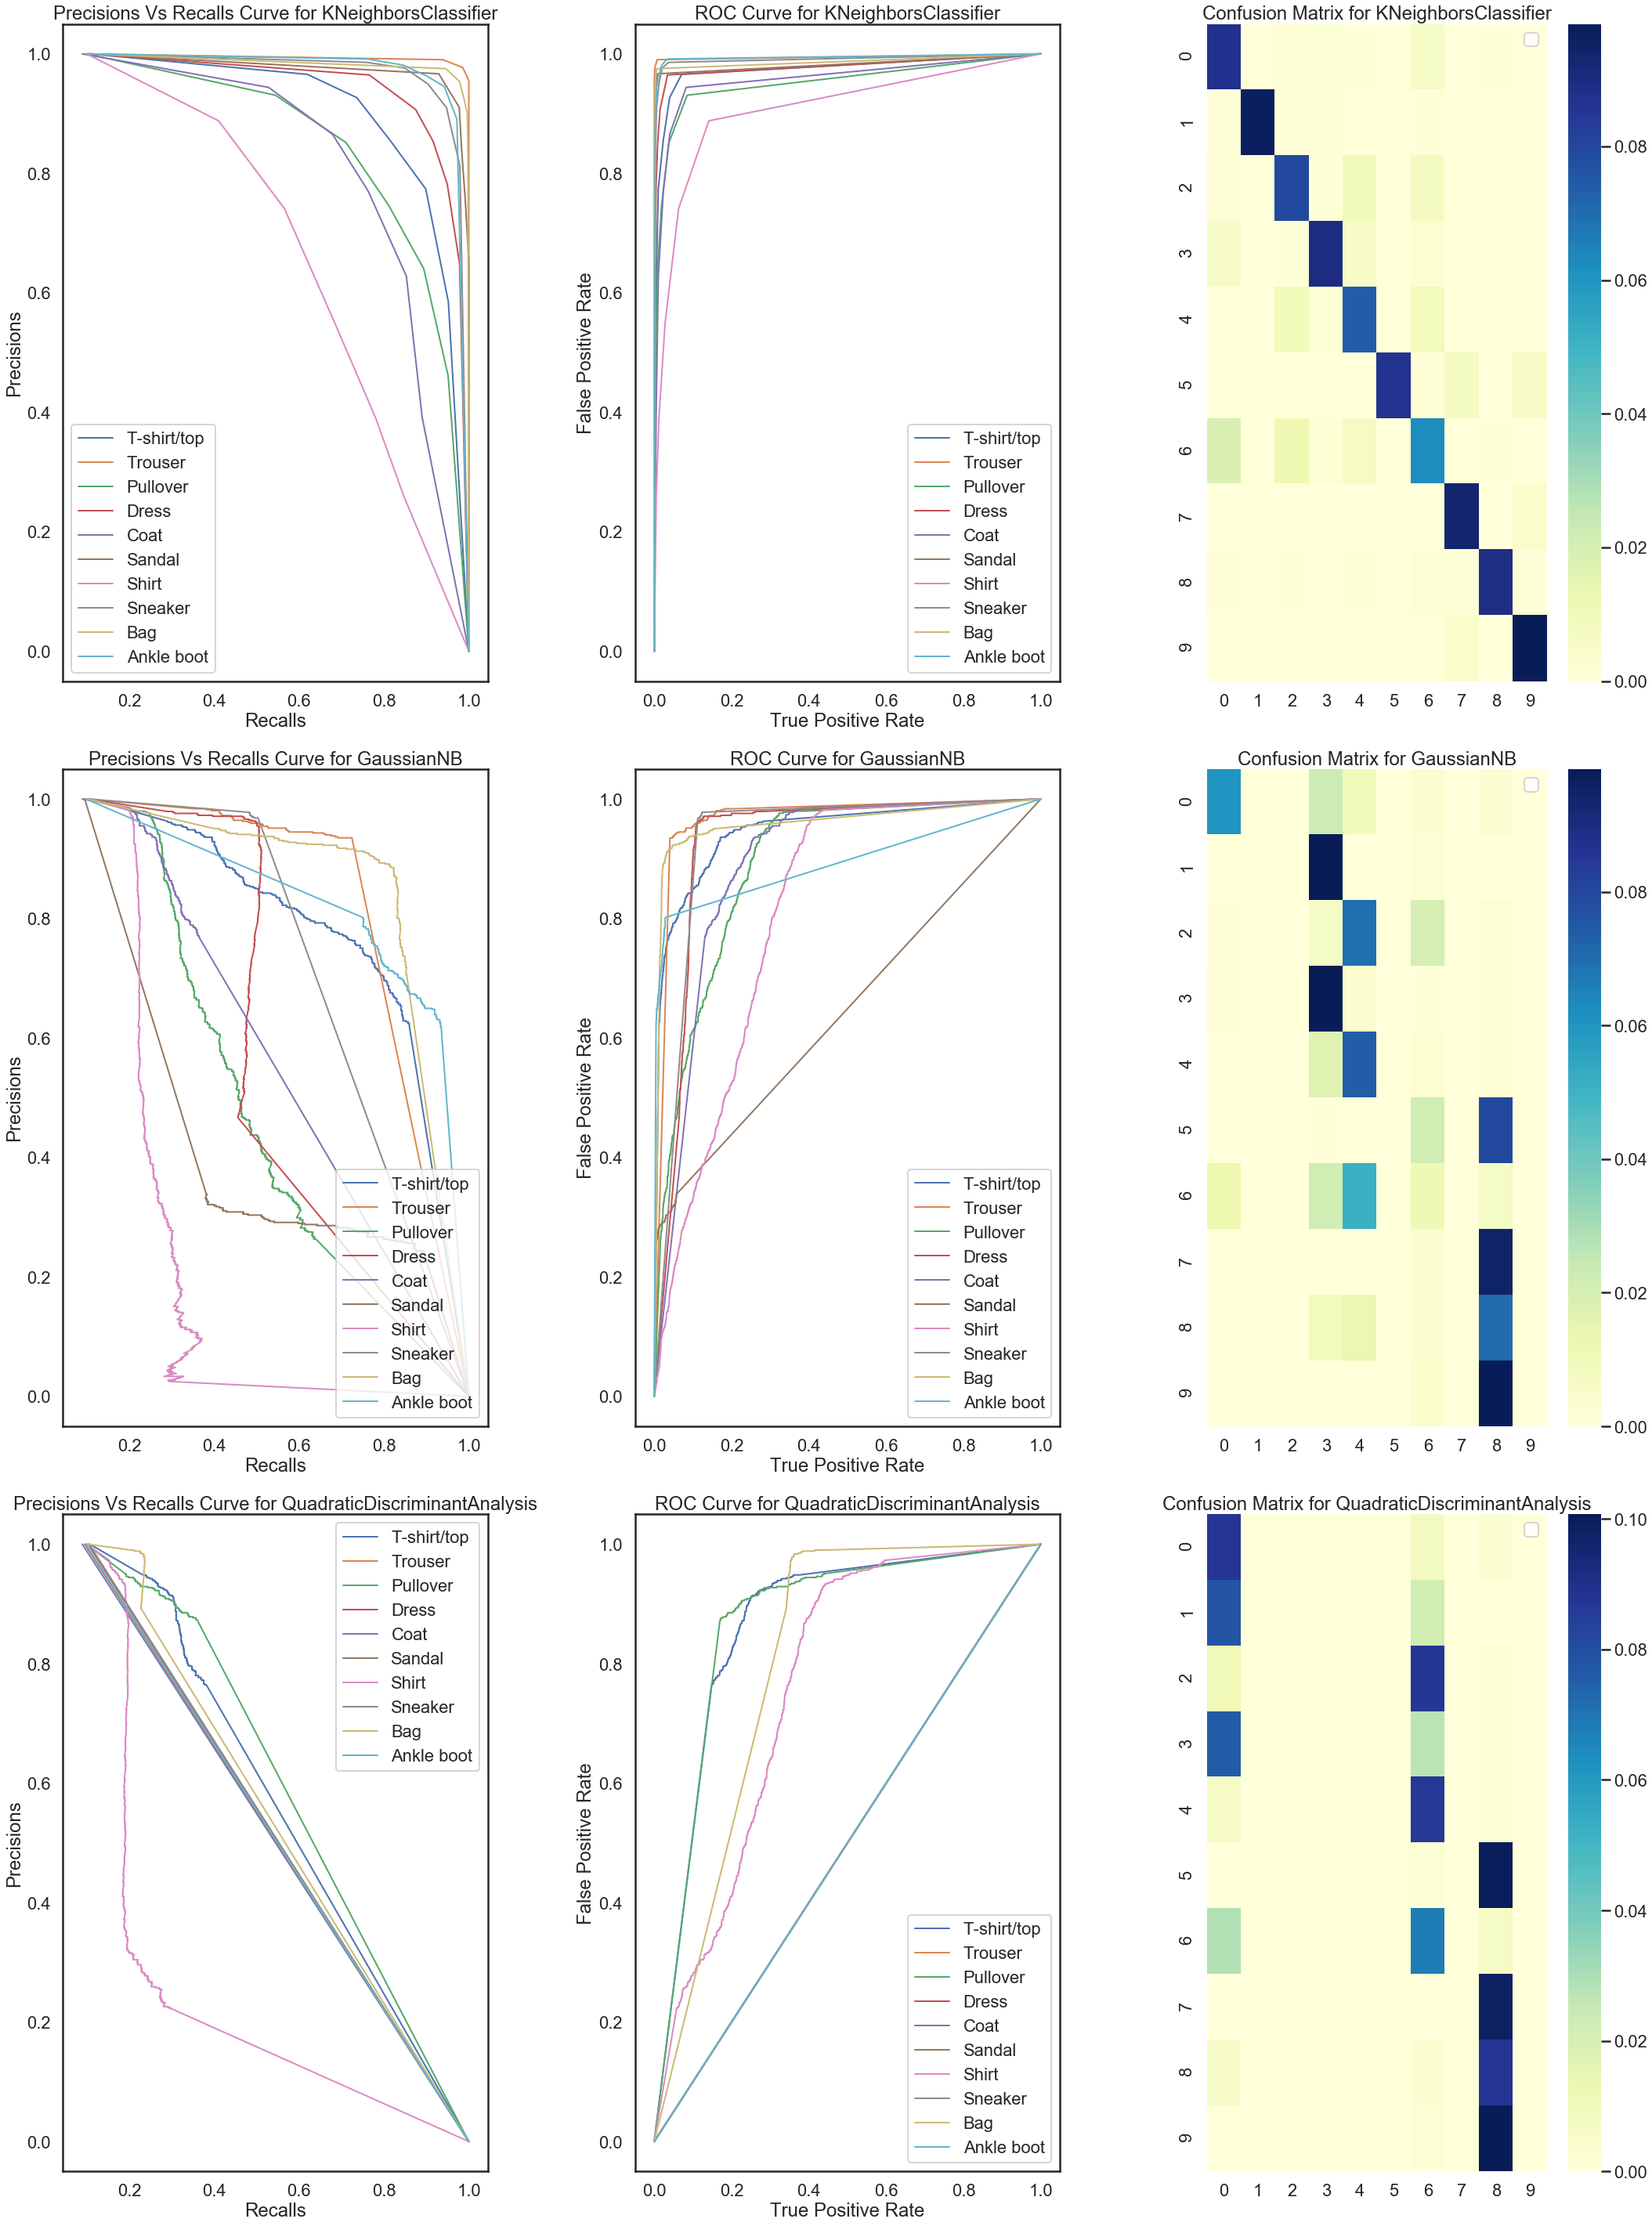

In [134]:
comparator_lowdim.set_estimators(non_linear_estimators)
comparator_lowdim.comparing()

Creating a model for AdaBoostClassifier
Setting model evaluator for the model of AdaBoostClassifier
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


Creating a model for BaggingClassifier
Setting model evaluator for the model of BaggingClassifier
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


Creating a model for GradientBoostingClassifier
Setting model evaluator for the model of GradientBoostingClassifier
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


Creating a model for RandomForestClassifier
Setting model evaluator for the model of RandomForestClassifier
Calculating the cross validation scores
Calculating the confusion matrix


No handles with labels found to put in legend.


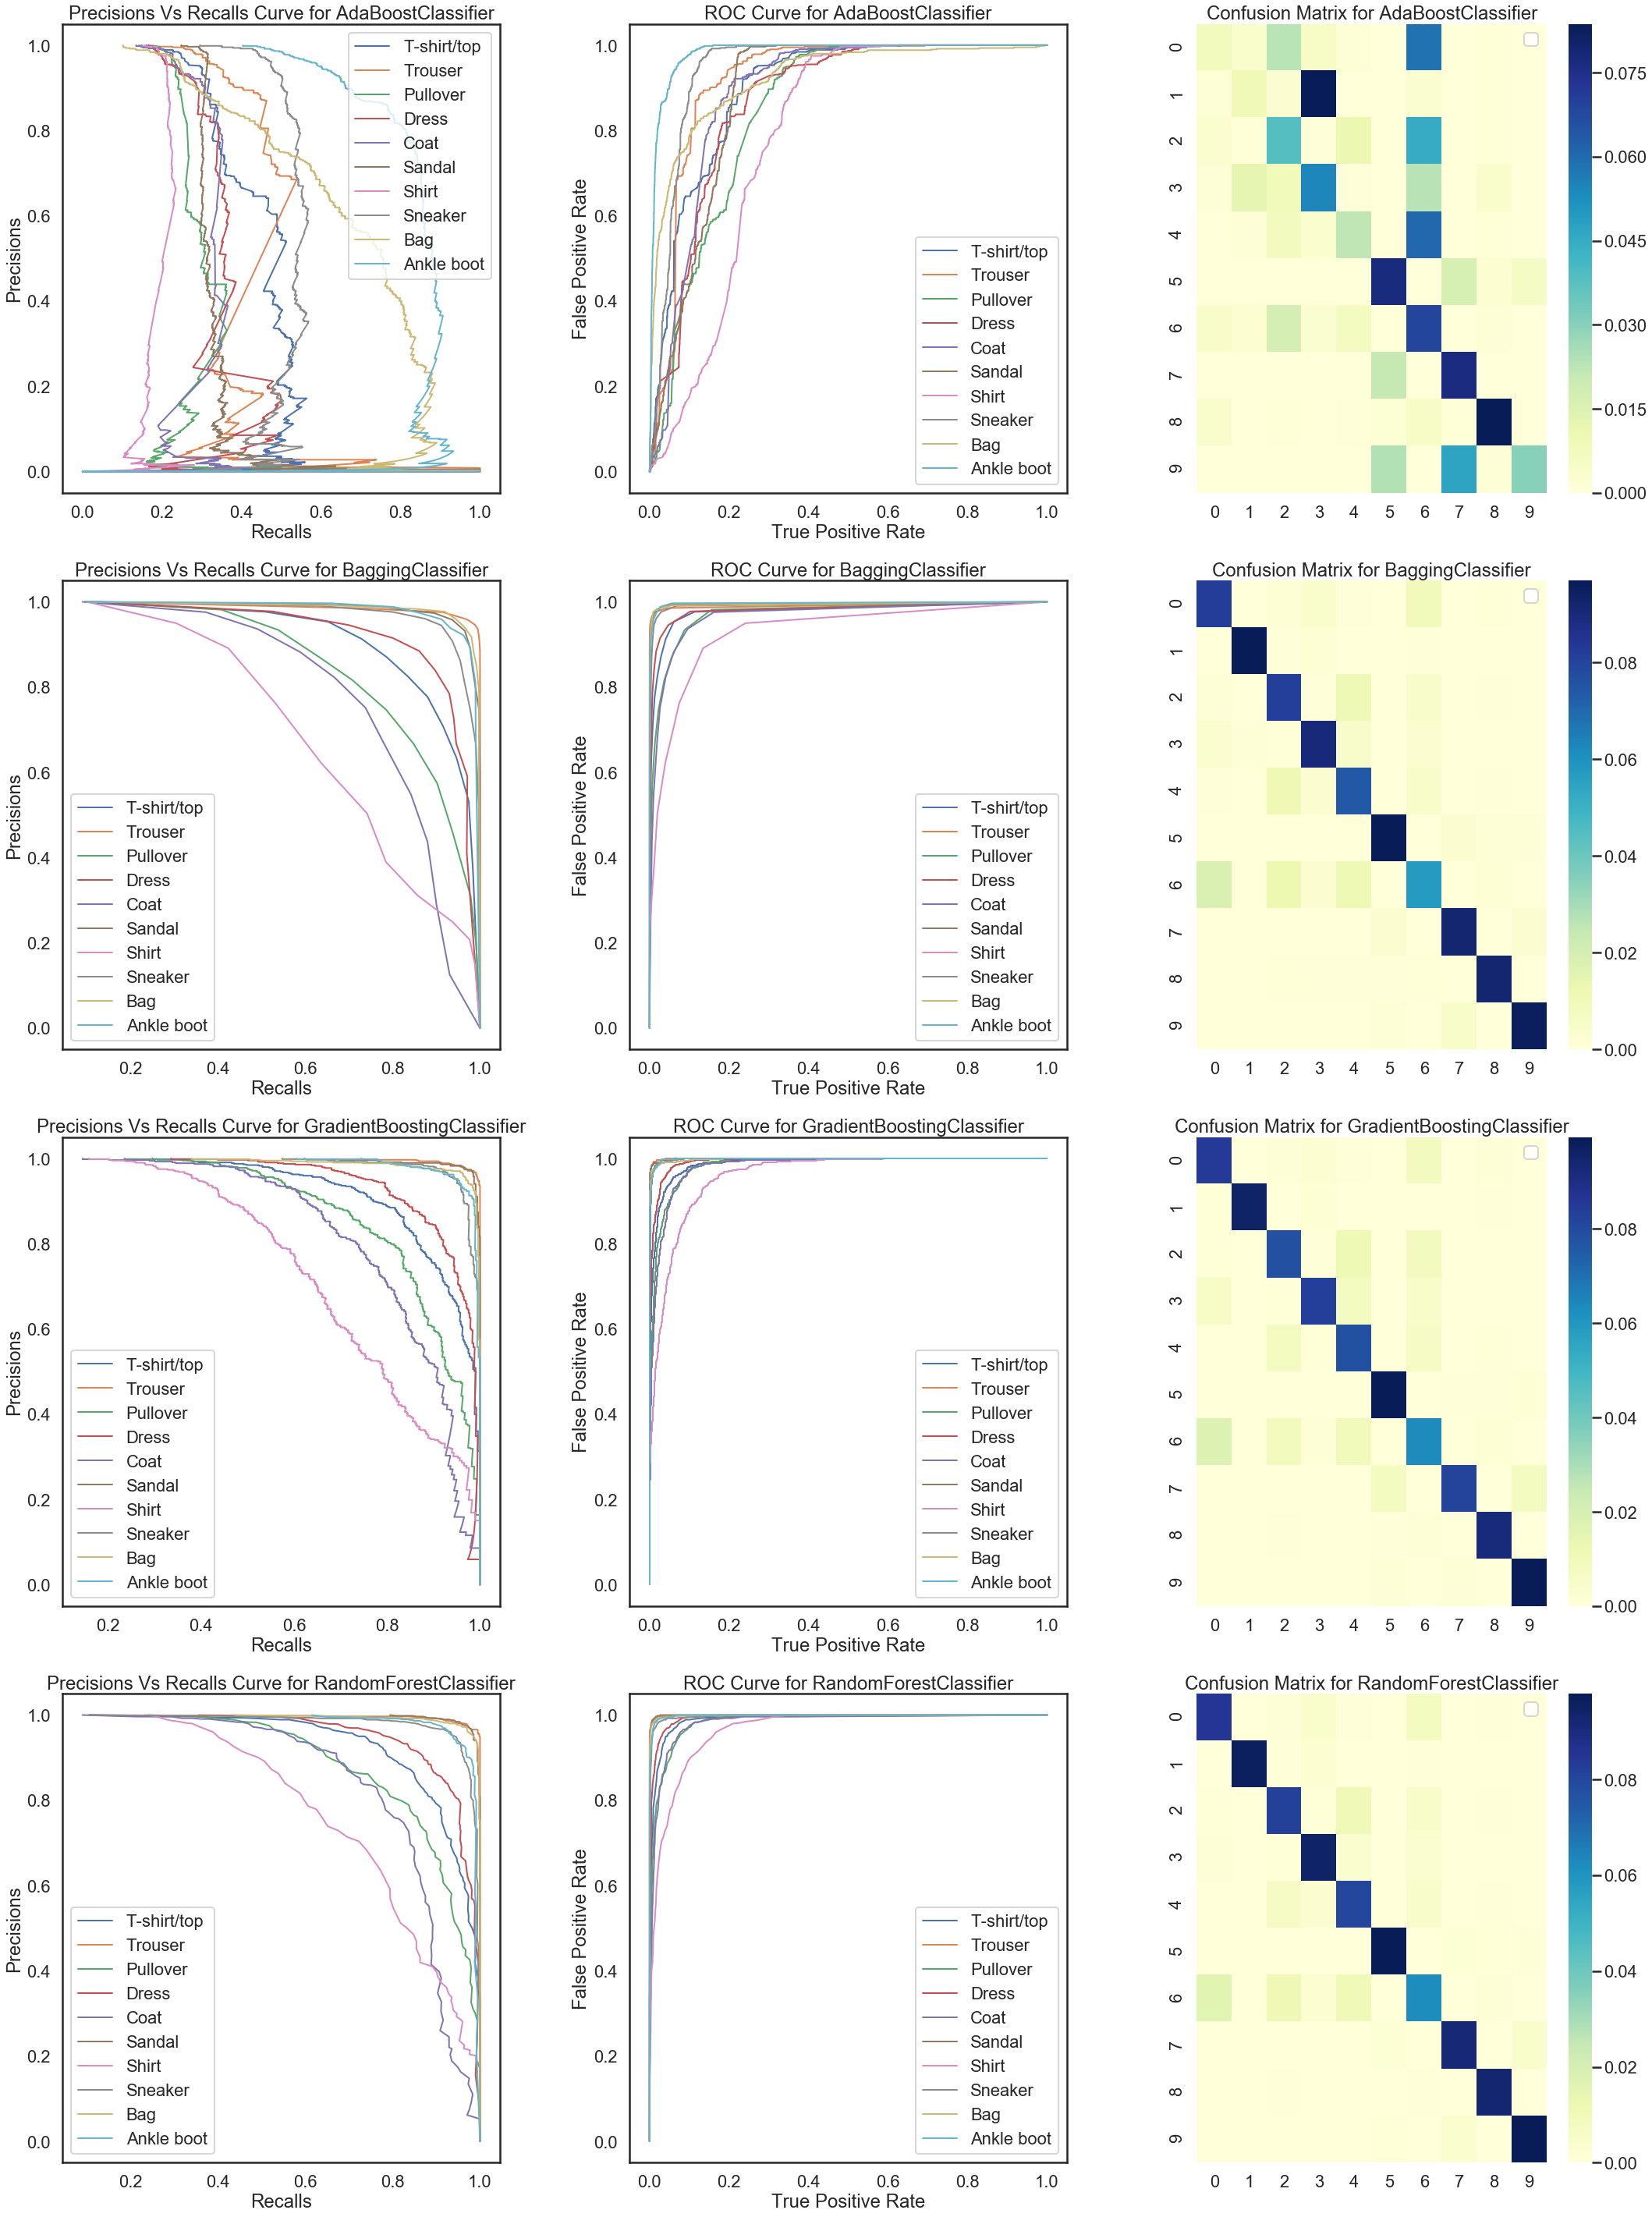

In [135]:
comparator_lowdim.set_estimators(ensembles)
comparator_lowdim.comparing()

In [56]:
# UMAP for Supervised Dimension Reduction and Metric Learning
import umap
plotting_data = np.float64(fashion.get_data()) / 255.0
plotting_target = np.float64(fashion.get_labels())
plotting_target_names = fashion.get_label_names()
sns.set(style = 'white', context = 'poster')

In [52]:
#First we’ll just do standard unsupervised dimension reduction using UMAP so we have a baseline of what the results
# look like for later comparison
embedding = umap.UMAP(n_neighbors = 5).fit_transform(plotting_data)

c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\numba\typed_passes.py:292: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python38\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


Text(0.5, 1.0, 'Fashion MNIST Embedded via UMAP')

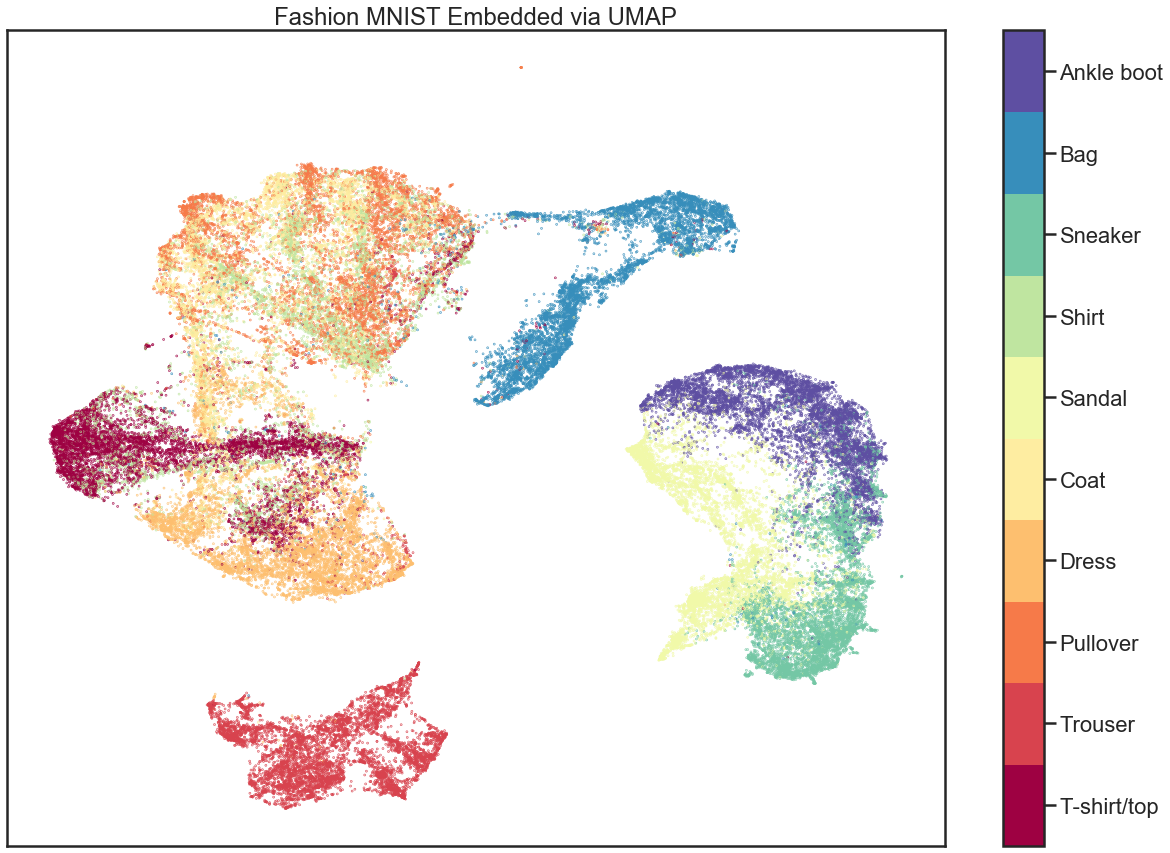

In [58]:
fig, ax = plt.subplots(1, figsize = (21, 15))
plt.scatter(*embedding.T, s = 0.3, c = plotting_target, cmap = 'Spectral', alpha = 1.0)
plt.setp(ax, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(11) - 0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(plotting_target_names)
plt.title('Fashion MNIST Embedded via UMAP')

In [59]:
# Using labels to separate classes, supervised umap
embedding_supervised = umap.UMAP().fit_transform(plotting_data, y = plotting_target)

c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\numba\typed_passes.py:292: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python38\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  warnings.warn(errors.NumbaPerformanceWarning(msg,
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\umap\spectral.py:227: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)


Text(0.5, 1.0, 'Fashion MNIST Embedded via UMAP using Labels')

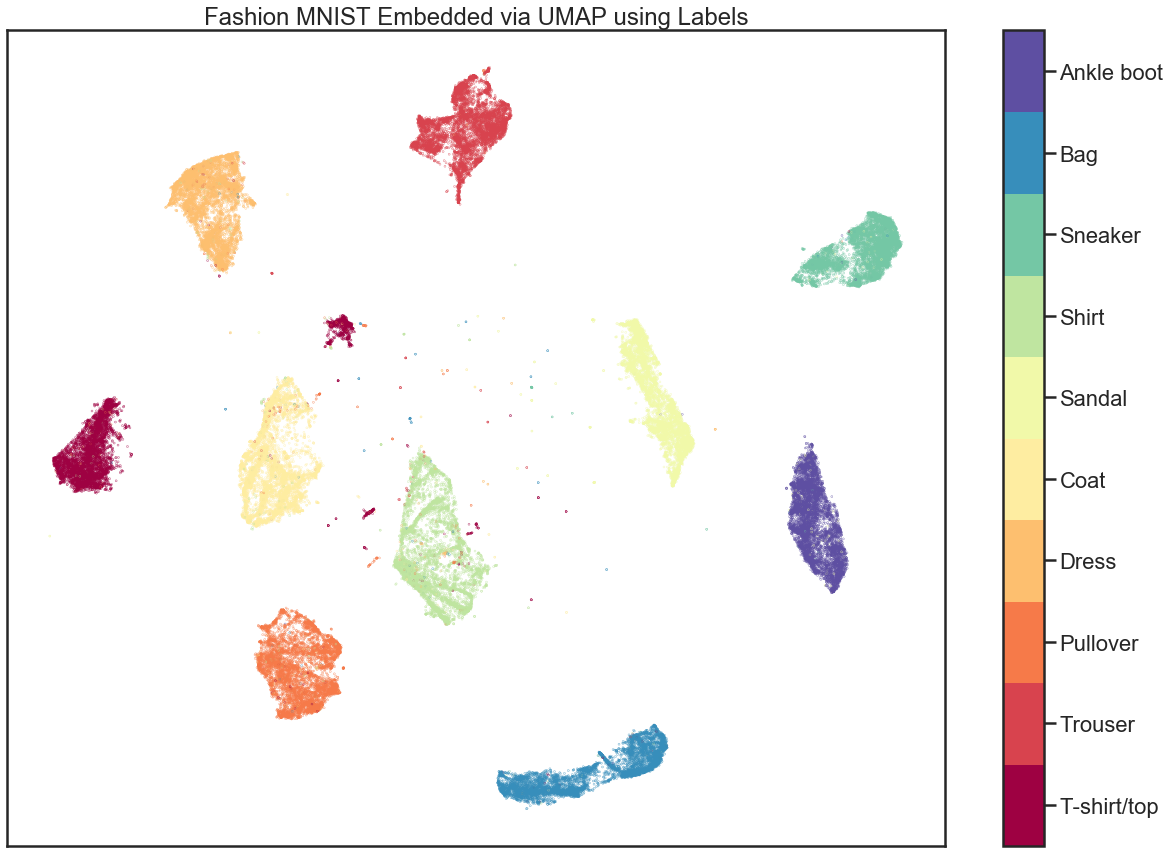

In [61]:
fig_label, ax_label = plt.subplots(1, figsize = (21, 15))
plt.scatter(*embedding_supervised.T, s = 0.1, c = plotting_target, cmap = 'Spectral', alpha = 1.0)
plt.setp(ax_label, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(11) - 0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(plotting_target_names)
plt.title('Fashion MNIST Embedded via UMAP using Labels')

In [62]:
# Using partial labelling, semi-supervised UMAP
# We’ll mask some of the target information, we’ll do this by using the sklearn standard of having unlabelled
# point be given the label of -1 (such as, for example, the noise points from a DBSCAN clustering).
masked_target = plotting_target.copy().astype(np.int8)
masked_target[np.random.choice(70000, size = 10000, replace = False)] = -1

# Now that we have randomly masked some of the labels we can try to perform supervised learning again.
# Everything works as before, but UMAP will interpret the -1 label as beingan unlabelled point and learn accordingly.
fitter = umap.UMAP().fit(plotting_data, y = masked_target)
embedding = fitter.embedding_

c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\numba\typed_passes.py:292: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\appdata\local\programs\python\python38\lib\site-packages\umap\nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  warnings.warn(errors.NumbaPerformanceWarning(msg,


Text(0.5, 1.0, 'Fashion MNIST Embedded via UMAP using Partial Labels(Semi-Supervised)')

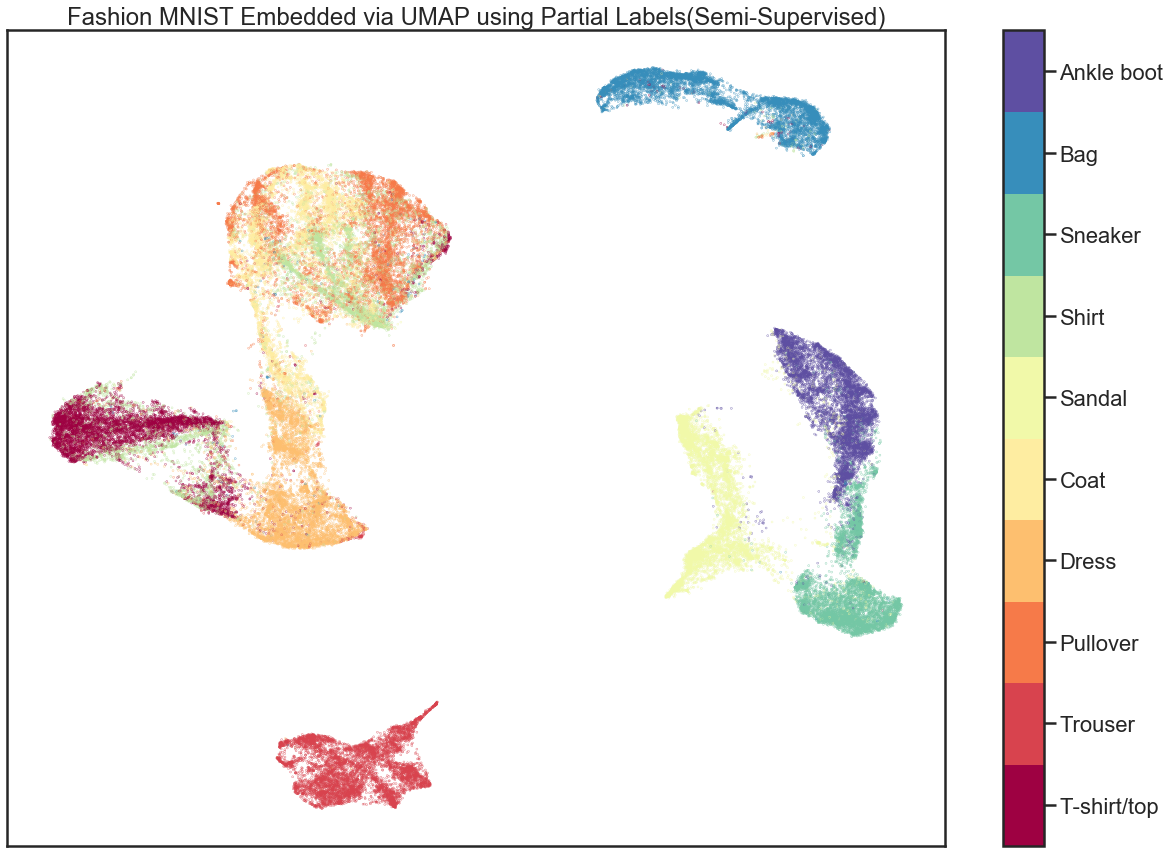

In [64]:
fig_semi, ax_semi = plt.subplots(1, figsize = (21, 15))
plt.scatter(*embedding.T, s = 0.1, c = plotting_target, cmap = 'Spectral', alpha = 1.0)
plt.setp(ax_semi, xticks = [], yticks = [])
cbar = plt.colorbar(boundaries = np.arange(11) - 0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(plotting_target_names)
plt.title('Fashion MNIST Embedded via UMAP using Partial Labels(Semi-Supervised)')

In [112]:
# Create a helper class for selecting the well tuned models
# This class is inspired by David S. Batista
# from sklearn.base import BaseEstimator, ClassifierMixin
# This class should be used for final tuning on selected model
# It's definetly not suitable for the first filteration
"""
class ModelSelector:
    
    __init__ function
    
    Parameters:
    @models: the models need to be tuned. 
    @params: a list of dics, stores the hyperparameters which need to be tuned. the keys are the
             names of the models, the values are dictionaries store expected values

    def __init__(self):
        
        # param_keys = set()
        # for i in range(len(params)):
        #     param_keys.add(list(params[i].keys())[0])
            
        # if not set(models.keys()).issubset(set(param_keys)):
        #     missing_params = list(set(models.keys()) - param_keys)
        #     raise ValueError('Some models are missing parameters: %s' % missing_params)
        # self.models = models
        
        # dict_params = {}
        # for param in params:
        #     dict_params.update(param)
        # self.params = dict_params
        
        # self.model stores the models
        self.model = []
        
        # self.param_grid stores the params
        self.param_grid = []
        
        # The grid_searches list stores instantiated GridSearchCV objects for models with
        # different hyperparameters
        self.grid_searches = {}
        
        # self.scorer stores the variables 'scorer_' from each GridSearchCV if the 
        # argument 'scoring' is set to specific strategies, not None
        self.scorer = {}
        
        # If the argument scoring of GridSearchCV was set to None, then the variable
        # remains False, else it's turned to True
        self.scorer_flag = False

    
    def fit(self, model, param_grid, X, y, cv = 3, n_jobs = -1, verbose = 1, scoring = None, refit = False):
        if scoring == None:
            self.scorer_flag = False
        else:
            self.scorer_flag = True
        
        print('Running GridSearchCV for %s.' % model.__class__.__name__)
        print(param_grid)
        gs = GridSearchCV(model, param_grid, cv = cv, n_jobs = n_jobs, scoring = scoring, 
                             refit = refit, return_train_score = True)
        gs.fit(X, y)
        self.grid_searches[model.__class__.__name__] = gs
            
    def score_summerization(self, sort_by = 'mean_score'):
        # Define a inner class for storing the scores for each model
        def row(name, scores, params):
            item = {
                'model': key, 
                'min_score': min(scores), 
                'max_score': max(scores), 
                'mean_score': np.mean(scores), 
                'std_score': np.std(scores)
            }
            return pd.Series({**params, **item})
        
        rows = [] # Creating a list stores score information for each model
        model_names = self.grid_searches.keys()
        for name in model_names:
            # The key 'params' is used to store a list of parameter setting dicts for
            # all the parameter candidates
            params = self.grid_searches[name].cv_results_['params'] 
            
            cv_scores = [] # Creating a list contains all the cross_validation scores we
            cv_folds = slef.grid_searches[name].n_splits_
            
            for itr in range(cv_folds):
                key_for_test = f'split{itr}_test_score' 
                # key_for_train = f'split{itr}_train_score'
                
                # split_train_score = self.grid_searches[name].cv_results_[key_for_train]
                # cv_scores.append(split_train_score.reshape(len(params), 1))
                
                split_test_score = self.grid_searches[name].cv_results_[key_for_test]
                cv_scores.append(split_test_score.reshape(len(params), 1))
                
                if refit is not None:
                    
                    best_model = self.grid_searches[name].best_estimator_
                    self.best_models.append(best_model)
                
                    self.best_params[name] = self.grid_searches[name].best_params_
            
            cv_scores = np.hstack(cv_scores)
            
            for param, cv_score in zip(params, cv_scores):
                rows.append((row(name, param, cv_score)))
            
        df = pd.concat(rows, axis = 1).T.sort_values([sort_by], ascending = False)
            
        columns = ['model', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [col for col in df.columns if col not in columns]
            
        return df[columns]
        
    def tuned_model_scorer(self):
        if len(gs) == 0:
            print('Not been initiated yet')
            raise ValueError()
        if self.scorer_flag:
            for key in self.keys():
                self.scorer[key] = self.grid_searches[key].scorer_
        else:
            print('The parameter scoring was set to None')
            raise ValueError('Reset scoring to any scoring strategy')
            
        return self.scorer
"""

In [ ]:
# The best approach for tuning an estimator is the GridSearchCV. However, since the dataset is not too small
# and we have a bunch of estimators need being tunned, the GridSearchCV will spend more than one day on
# tunning these estimators. So, RandomizedSearchCV might be a better practice
# In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings
# is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

In [115]:
model = SVC()
param_grid = {'C': [1, 10], 'kernel': ['linear', 'rbf']}

In [109]:
# models = {
#     'sgd_clf': OneVsRestClassifier(SGDClassifier())
    # 'rig_clf': RidgeClassifier(),
    # 'log_reg_clf': LogisticRegression(multi_class = 'ovr'), 
    # 'pac_clf': PassiveAggressiveClassifier()
# }

# params = {
   # 'sgd_clf__estimator__max_iter': np.array(['50', '100', '200', '400']).astype(np.float), 
   # 'sgd_clf__estimator__alpha': np.array(['0.0001', '0.001', '0.01', '0.1']).astype(np.float), 
   # 'sgd_clf': {'estimator__penalty': np.array(['None', 'l1', 'l2'])}

   # 'rig_clf': {
   #      'alpha': np.array(['0.5', '1.0', '1.5', '2.0', '2.5']).astype(np.float),
   #      'solver': np.array(['auto', 'svd', 'cholesky'])
   #  } 
   # 'log_reg_clf': {
   #     #'dual': (True, False),
   #     'C': np.array([0.1, 0.5, 1, 1.5, 2.0]).astype(np.float)
   # }, 
   # 'pac_clf': {
   #     'C': np.array([0.1, 0.5, 1, 1.5, 2.0]).astype(np.float), 
   #     'loss': ['hinge', 'squared_hinge']
   # }
# }
scoring = {
    'roc_auc': make_scorer(roc_auc_score, average = 'weighted', multi_class = 'ovr'),
    'f1': make_scorer(f1_score, average = 'weighted'), 
    'precision': make_scorer(precision_score, average = 'weighted'), 
    'recall': make_scorer(recall_score, average = 'weighted')
}

In [110]:
data_train_scale = StandardScaler().fit_transform(data_train)

In [90]:
# Now, we are going to comparing the classification models 
# sklearn also provides neural_network called MLPClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [120]:
svc = SVC()
parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10]}
clf = GridSearchCV(svc, parameters)

In [124]:
label_train = label_train.reshape([60000, 1])

In [125]:
label_train.shape

(60000, 1)

In [126]:
clf.fit(data_train_scale, label_train)

c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\3056986\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:760: DataC

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)